# Colorectal histology dataset with LeNet 5

# Preview: Neural Network examples with `tf.keras`

- `tf.keras` Software (http://keras.io/);

- Visual example of LeNet-5 (http://yann.lecun.com/exdb/lenet/) using MNIST digits dataset;

- Examples with common neural network topologies (https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/).

## Colorectal histology

Methods to diagnose colorectal using histology images (<https://zenodo.org/record/53169#.XGZemKwzbmG>, <https://www.tensorflow.org/datasets/catalog/colorectal_histology>)

In this case, the purpose is to classify the type of histology in a given image in the following categories:

- 0: TUMOR
- 1: STROMA
- 2: COMPLEX
- 3: LYMPHO
- 4: DEBRIS
- 5: MUCOSA
- 6: ADIPOSE
- 7: EMPTY

## Local instalation (option 1)

Install the following Python packages to run this notebook

`pip install pip -U`

`pip install tensorflow jupyter`

## Google Colab (option 2)

[Google Colab](https://colab.research.google.com/) is a research project created to help disseminate machine learning education and research. It's a `Jupyter notebook` environment that requires no setup to use and runs entirely in the cloud.

Colaboratory notebooks are stored in [Google Drive](https://drive.google.com) and can be shared just as you would with Google Docs or Sheets. Colaboratory is free to use.

For more information, see our [FAQ](https://research.google.com/colaboratory/faq.html).

### How install extra packages
Google Colab installs a series of basic packages if we need any additional package just install it.

In [ ]:
!pip install -q keras sklearn

## Import packages

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

## Define global constants

Lets start with a few epochs to test learning network parameters

In [9]:
#Function to set the number of epochs and batches
def set_epochs_batches(epochs_number , batches ): 
  epochs= epochs_number
  batch_size = batches
  return 

In [10]:
batch_size = 34 #Number of training examples
nb_classes = 2  #or 8
epochs = 5 #Number of iterations // Passes the entire training has completed
# Scaling input image to theses dimensions
img_rows, img_cols = 32, 32

## Load image database

In [11]:
def format_example(image):
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # Resize the image
    image = tf.image.resize(image, (img_rows, img_cols))
    return image


def load_data(name="colorectal_histology"):
  train_ds = tfds.load(name, split=tfds.Split.TRAIN, batch_size=-1)
  train_ds['image'] = tf.map_fn(format_example, train_ds['image'], dtype=tf.float32)
  numpy_ds = tfds.as_numpy(train_ds)
  X, y = numpy_ds['image'], numpy_ds['label']

  return np.array(X), np.array(y)

## Plot images

In [12]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(25, 2))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,:])
        plt.gray()
        ax.set_title(f'{y[index[i]]}-{index[i]}')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Build LeNet5 structure

<center><img src="https://www.dlsi.ua.es/~juanra/UA/curso_verano_DL/images/LeNet5.jpg"></center>

In [13]:
#
# Build an ANN structure - LeNet5
#
# The model will receive the activation functions
def cnn_model(activation_functions):
    #
    # Neural Network Structure
    #
    
    model = Sequential()
    
    
    model.add(layers.Conv2D(6, (5, 5))) #Output dimensionality, kernel_size (Height, width)
    model.add(layers.Activation(activation_functions[0])) #Applies an activation function to an output
    model.add(layers.MaxPooling2D(pool_size=(2, 2))) #Getting a size 2x2 for the window
    
    model.add(layers.Conv2D(16, (5, 5)))
    model.add(layers.Activation(activation_functions[1]))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
    model.add(layers.Flatten())
    
    model.add(layers.Dense(120)) #dense(Dimensionality of the output space)
    model.add(layers.Activation(activation_functions[2]))
    
    model.add(layers.Dense(84))
    model.add(layers.Activation(activation_functions[3]))
    
    model.add(layers.Dense(nb_classes))
    model.add(layers.Activation(activation_functions[4]))

    return model

## Start to run the program

### Load data

In [14]:
##################################################################################
# Main program

X, y = load_data()
print("Los resultados que hemos obtenido, son los siguientes")

print(X.shape, 'train samples')
print(img_rows,'x', img_cols, 'image size')
print(epochs,'epochs')

Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteBPCKDU/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
Los resultados que hemos obtenido, son los siguientes
(5000, 32, 32, 3) train samples
32 x 32 image size
5 epochs


Only for binary classification. All number of classes greater than 0 will be set to 1.

In [15]:
if nb_classes==2:
  y[y>0] = 1

### Let to see examples of the dataset

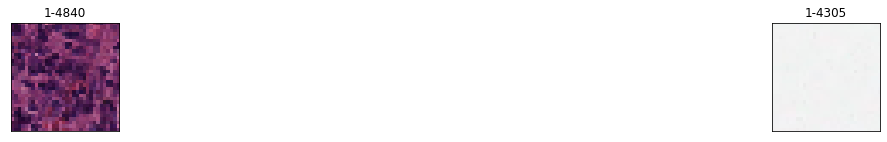

In [16]:
plot_symbols(X, y, 2)

## Number of examples per class

In [17]:
collections.Counter(y)

Counter({0: 625, 1: 4375})

## Split examples in training/test sets

#Fucntion to create some models with different epochs in order to compare each other and get the best one

In [77]:
import time
#Vamos a ir lanzando varios modelos, creando un array de acc, y el que mejor resultados nos dé, es con el que nos vamos a quedar
def create_models_arrays_comparison(model_i):
  #Primero, cambiaremos las funciones de activación
  activation_functions = []
  activation_functions.append(["tanh", "tanh", "tanh", "tanh", "softmax"] )
  activation_functions.append(["sigmoid", "sigmoid" , "sigmoid", "sigmoid" , "softmax"])
  activation_functions.append( ["relu", "relu", "relu", "relu", "softmax"])
  activation_functions.append( ["tanh", "tanh", "tanh", "tanh", "relu"])
  activation_functions.append( ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "relu"])
  activation_functions.append( ["relu", "relu", "relu", "relu", "relu"])
  optimizers = ['adam' , 'sgd' , 'adadelta'] 
  augmentation = [True, False]
  best = 0
  best_optimizer = ''
  with_data_augmentation = False
  best_function = []
  best_epoch_number = 0
  best_batch_number = 0
  
  if model_i == 0: 
    #Iremos cambiando las épocas para cada uno de ellos (Épocas: de 5 a 15 ) 
    #También cambiaremos el número de batches (20 - 40)
    for activation_function in activation_functions: 
      for epoch_i  in range(5,15): 
        for batch_i in range(20,40):
          for optimizer_i in optimizers:
            for augmentation_i in augmentation: 
              set_epochs_batches(epoch_i , batch_i ) 
              #Getting the result
              acc_per_fold, loss_per_fold, auc_per_fold, y_pred, acc_percent_per_fold, model = cross_validation(10 , activation_function , optimizer_i , augmentation_i , batch_i, epoch_i  )
              plt.plot(range(len( acc_percent_per_fold)) , acc_percent_per_fold , 'ro-',label=activation_function[0] + ", " +  activation_function[4] + " [ " + epoch_i + ", " + batch_i + ", " + optimizer_i + ", " + augmentation_i  +" ]")
              #Getting the media_value
              total = 0
              for value in acc_per_fold: 
                total = total + value
              media_value = total/len(acc_per_fold)
              if media_value > best: 
                best = media_value
                best_function = activation_function
                best_epoch_number = epoch_i
                best_batch_number = batch_i
                best_optimizer =optimizer_i
                with_data_augmentation = augmentation_i
    
    print("THE BEST MODEL IS " + bect_function )
    print("WITH A EPOCH_NUMBER OF " + best_epoch_number + " AND A BATCH SIZE OF " + best_batch_number )
    print("AND WITH THE OPTIMIZER " + best_optimizer)
    print("AND WITH DATA_AUGMENTATION "  + with_data_augmentation )
    plt.ylabel('Aciertos')
    plt.xlabel('Fold')
    plt.legend()
    return

  if model_i == 1:  
    set_epochs_batches(5,34 ) #Probamos cuál es el mejor modelo con las mismas épocas y batches
    best_epoch = 5
    best_batch_number= 34

    #Pondremos el optimizador de adam
    for activation_function in activation_functions: 
      acc_per_fold, loss_per_fold, auc_per_fold, y_pred, acc_percent_per_fold, model = cross_validation(10 , activation_function , "adam" , False , 34,5)
      print("Sacando la gráfica del modelo")
      plt.plot(range(len( acc_percent_per_fold)) , acc_percent_per_fold , label=str(activation_function[0]) + ", " +  activation_function[4] )
      
      #Getting the media_value
      total = 0
      for value in acc_per_fold: 
        total = total + value
      media_value = total/len(acc_per_fold)
      if media_value > best: 
        best = media_value
        best_function = activation_function
        with_data_augmentation = False

    print("FIRST MODEL GRAPHIC")
    plt.ylabel('Aciertos')
    plt.xlabel('Fold')
    plt.legend()
   
    
    #Once we have the result, we create another loop in order to get the best epoch and batch model
    for epoch_i  in range(5,15): 
      for batch_i in range(20,40):
        for optimizer_i in optimizers:
          for augmentation_i in augmentation: 
            epochs = epoch_i
            batch_size = batch_i
            #set_epochs_batches(epoch_i , batch_i ) 
            print("The new size is " , str(epochs) , ", " , batch_size)
            #Getting the result
            acc_per_fold, loss_per_fold, auc_per_fold, y_pred, acc_percent_per_fold, model = cross_validation(10 , best_function , optimizer_i , augmentation_i , batch_i , epoch_i)
            plt.plot(range(len( acc_percent_per_fold)) , acc_percent_per_fold , label=activation_function[0] + ", " +  activation_function[4] + " [ " + str(epoch_i) + ", " + str(batch_i) + ", " + str(optimizer_i) + ", " + str(augmentation_i)  +" ]")
            #Getting the media_value
            total = 0
            for value in acc_per_fold: 
              total = total + value
            media_value = total/len(acc_per_fold)
            if media_value > best: 
              best = media_value
              best_epoch_number = epoch_i
              best_batch_number = batch_i
              best_optimizer =optimizer_i
              with_data_augmentation = augmentation_i 
    
    print("THE BEST MODEL IS " + bect_function )
    print("WITH A EPOCH_NUMBER OF " + best_epoch_number + " AND A BATCH SIZE OF " + best_batch_number )
    print("AND WITH THE OPTIMIZER " + best_optimizer)
    print("AND WITH DATA_AUGMENTATION "  + with_data_augmentation )
    print("FIRST MODEL GRAPHIC")
    plt.ylabel('Aciertos')
    plt.xlabel('Fold')
    plt.legend()
 
  return


In [ ]:
create_models_arrays_comparison(1)

Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 0.2098 - accuracy: 0.9107 - val_loss: 6.8820e-04 - val_accuracy: 1.0000
15/15 [==============================] - 0s 3ms/step - loss: 0.2839 - accuracy: 0.8840
loss: 0.28 acc: 0.88
Predictions Counter({1: 432, 0: 68}) 

Confusion matrix
[[ 36  26]
 [ 32 406]] 

              precision    recall  f1-score   support

       TUMOR       0.53      0.58      0.55        62
     HEALTHY       0.94      0.93      0.93       438

    accuracy                           0.88       500
   macro avg       0.73      0.75      0.74       500
weighted avg       0.89      0.88      0.89       500

AUC 0.8842 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_tra

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 3.5816 - accuracy: 0.6966 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 1.9986 - accuracy: 0.8760
loss: 2.00 acc: 0.88
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  62]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.88       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.88      0.82       500

AUC 0.5557 
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 7.1936 - accuracy: 0.5439 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8520
loss: 2.03 acc: 0.85
Predictions Counter({1: 486, 0: 14}) 

Confusion matrix
[[  1  61]
 [ 13 425]] 

              precision    recall  f1-score   support

       TUMOR       0.07      0.02      0.03        62
     HEALTHY       0.87      0.97      0.92       438

    accuracy                           0.85       500
   macro avg       0.47      0.49      0.47       500
weighted avg       0.77      0.85      0.81       500

AUC 0.7674 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 0.0614 - accuracy: 0.4440 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 1.1921e-07 - accuracy: 0.1260
loss: 0.00 acc: 0.13
Predictions Counter({0: 500}) 

Confusion matrix
[[ 63   0]
 [437   0]] 

              precision    recall  f1-score   support

       TUMOR       0.13      1.00      0.22        63
     HEALTHY       0.00      0.00      0.00       437

    accuracy                           0.13       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.13      0.03       500

AUC 0.5000 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 6.6885 - accuracy: 0.5727 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.5942 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 7.1580 - accuracy: 0.5558 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.4836 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 7.1228 - accuracy: 0.5559 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.8483 
Sacando la gráfica del modelo
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 8.9502 - accuracy: 0.4447 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 14.1195 - accuracy: 0.1240
loss: 14.12 acc: 0.12
Predictions Counter({0: 500}) 

Confusion matrix
[[ 62   0]
 [438   0]] 

              precision    recall  f1-score   support

       TUMOR       0.12      1.00      0.22        62
     HEALTHY       0.00      0.00      0.00       438

    accuracy                           0.12       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.12      0.03       500

AUC 0.5000 
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 1.1921e-07 - accuracy: 0.4447 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 1.1921e-07 - accuracy: 0.1240
loss: 0.00 acc: 0.12
Predictions Counter({0: 500}) 

Confusion matrix
[[ 62   0]
 [438   0]] 

              precision    recall  f1-score   support

       TUMOR       0.12      1.00      0.22        62
     HEALTHY       0.00      0.00      0.00       438

    accuracy                           0.12       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.12      0.03       500

AUC 0.5000 
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 1.1921e-07 - accuracy: 0.4447 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 1.1921e-07 - accuracy: 0.1240
loss: 0.00 acc: 0.12
Predictions Counter({0: 500}) 

Confusion matrix
[[ 62   0]
 [438   0]] 

              precision    recall  f1-score   support

       TUMOR       0.12      1.00      0.22        62
     HEALTHY       0.00      0.00      0.00       438

    accuracy                           0.12       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.12      0.03       500

AUC 0.5000 
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 8.9502 - accuracy: 0.4447 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 14.1195 - accuracy: 0.1240
loss: 14.12 acc: 0.12
Predictions Counter({0: 500}) 

Confusion matrix
[[ 62   0]
 [438   0]] 

              precision    recall  f1-score   support

       TUMOR       0.12      1.00      0.22        62
     HEALTHY       0.00      0.00      0.00       438

    accuracy                           0.12       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.12      0.03       500

AUC 0.5000 
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 0.6910 - accuracy: 0.5584 - val_loss: 0.7255 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 0.6192 - accuracy: 0.8760
loss: 0.62 acc: 0.88
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  62]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.88       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.88      0.82       500

AUC 0.7731 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 1.1921e-07 - accuracy: 0.4441 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 1.1921e-07 - accuracy: 0.1260
loss: 0.00 acc: 0.13
Predictions Counter({0: 500}) 

Confusion matrix
[[ 63   0]
 [437   0]] 

              precision    recall  f1-score   support

       TUMOR       0.13      1.00      0.22        63
     HEALTHY       0.00      0.00      0.00       437

    accuracy                           0.13       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.13      0.03       500

AUC 0.5000 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 0.6945 - accuracy: 0.5507 - val_loss: 0.8400 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 0.5955 - accuracy: 0.8740
loss: 0.60 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.2349 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 7.1580 - accuracy: 0.5559 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.5000 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 1.1921e-07 - accuracy: 0.4441 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 1.1921e-07 - accuracy: 0.1260
loss: 0.00 acc: 0.13
Predictions Counter({0: 500}) 

Confusion matrix
[[ 63   0]
 [437   0]] 

              precision    recall  f1-score   support

       TUMOR       0.13      1.00      0.22        63
     HEALTHY       0.00      0.00      0.00       437

    accuracy                           0.13       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.13      0.03       500

AUC 0.5000 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 7.1580 - accuracy: 0.5559 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.3581 
Sacando la gráfica del modelo
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 1.1390 - accuracy: 0.4447 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 1.9342 - accuracy: 0.1240
loss: 1.93 acc: 0.12
Predictions Counter({0: 500}) 

Confusion matrix
[[ 62   0]
 [438   0]] 

              precision    recall  f1-score   support

       TUMOR       0.12      1.00      0.22        62
     HEALTHY       0.00      0.00      0.00       438

    accuracy                           0.12       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.12      0.03       500

AUC 0.5000 
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 6.8448 - accuracy: 0.5705 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 1.9986 - accuracy: 0.8760
loss: 2.00 acc: 0.88
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  62]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.88       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.88      0.82       500

AUC 0.6084 
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 0.3683 - accuracy: 0.8860 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 0.5774 - accuracy: 0.8540
loss: 0.58 acc: 0.85
Predictions Counter({1: 457, 0: 43}) 

Confusion matrix
[[ 16  46]
 [ 27 411]] 

              precision    recall  f1-score   support

       TUMOR       0.37      0.26      0.30        62
     HEALTHY       0.90      0.94      0.92       438

    accuracy                           0.85       500
   macro avg       0.64      0.60      0.61       500
weighted avg       0.83      0.85      0.84       500

AUC 0.6040 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 1.1921e-07 - accuracy: 0.4441 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
15/15 [==============================] - 0s 2ms/step - loss: 1.1921e-07 - accuracy: 0.1260
loss: 0.00 acc: 0.13
Predictions Counter({0: 500}) 

Confusion matrix
[[ 63   0]
 [437   0]] 

              precision    recall  f1-score   support

       TUMOR       0.13      1.00      0.22        63
     HEALTHY       0.00      0.00      0.00       437

    accuracy                           0.13       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.13      0.03       500

AUC 0.5000 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   34 ,  5
209/209 - 1s - loss: 7.0625 - accuracy: 0.5426 - val_loss: 16.1181 - val_accuracy: 0.0000e+00
15/15 [==============================] - 0s 2ms/step - loss: 1.8375 - accuracy: 0.8680
loss: 1.84 acc: 0.87
Predictions Counter({1: 485, 0: 15}) 

Confusion matrix
[[  6  57]
 [  9 428]] 

              precision    recall  f1-score   support

       TUMOR       0.40      0.10      0.15        63
     HEALTHY       0.88      0.98      0.93       437

    accuracy                           0.87       500
   macro avg       0.64      0.54      0.54       500
weighted avg       0.82      0.87      0.83       500

AUC 0.6880 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   20 ,  5
Epoch 0
355/355 - 1s - loss: 0.2232 - accuracy: 0.9111 - val_loss: 1.4531e-04 - val_accuracy: 1.0000
1
393.9
355/355 - 1s - loss: 0.1468 - accuracy: 0.9382 - val_loss: 0.0027 - val_accuracy: 1.0000
2
393.9
355/355 - 1s - loss: 0.0976 - accuracy: 0.9612 - val_loss: 1.6928e-05 - val_accuracy: 1.0000
3
393.9
355/355 - 1s - loss: 0.0857 - accuracy: 0.9678 - val_loss: 7.1404e-05 - val_accuracy: 1.0000
4
393.9
355/355 - 1s - loss: 0.0725 - accuracy: 0.9717 - val_loss: 5.1354e-04 - val_accuracy: 1.0000
5
393.9
355/355 - 1s - loss: 0.0669 - accuracy: 0.9752 - val_loss: 1.9193e-05 - val_accuracy: 1.0000
6
393.9
355/355 - 1s - loss: 0.0603 - accuracy: 0.9760 - val_loss: 0.0040 - val_accuracy: 1.0000
7
393.9
355/355 - 1s - loss: 0.0534 - accuracy: 0.9810 - val_loss: 3.9339e-06 - val_accuracy: 1.0000
8
393.9


25/25 [==============================] - 0s 3ms/step - loss: 0.3814 - accuracy: 0.9620
loss: 0.38 acc: 0.96
Predictions Counter({1: 445, 0: 55}) 

Confusion matrix
[[ 49  13]
 [  6 432]] 

              precision    recall  f1-score   support

       TUMOR       0.89      0.79      0.84        62
     HEALTHY       0.97      0.99      0.98       438

    accuracy                           0.96       500
   macro avg       0.93      0.89      0.91       500
weighted avg       0.96      0.96      0.96       500

AUC 0.9430 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   20 ,  5
Epoch 0
355/355 - 1s - loss: 0.2216 - accuracy: 0.9127 - val_loss: 1.9274e-04 - val_accuracy: 1.0000
1
393.9
355/355 - 1s - loss: 0.1381 - accuracy: 0.9440 - val_loss: 6.3060e-05 - val_accuracy: 1.0000
2
393.9
355/355 - 1s - loss: 0.1290 - accura

25/25 [==============================] - 0s 3ms/step - loss: 0.3319 - accuracy: 0.9540
loss: 0.33 acc: 0.95
Predictions Counter({1: 450, 0: 50}) 

Confusion matrix
[[ 45  18]
 [  5 432]] 

              precision    recall  f1-score   support

       TUMOR       0.90      0.71      0.80        63
     HEALTHY       0.96      0.99      0.97       437

    accuracy                           0.95       500
   macro avg       0.93      0.85      0.89       500
weighted avg       0.95      0.95      0.95       500

AUC 0.9038 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   20 ,  5
Epoch 0
355/355 - 1s - loss: 0.2184 - accuracy: 0.9132 - val_loss: 0.0011 - val_accuracy: 1.0000
1
393.6
355/355 - 1s - loss: 0.1416 - accuracy: 0.9409 - val_loss: 1.4507e-04 - val_accuracy: 1.0000
2
393.6
355/355 - 1s - loss: 0.1141 - accuracy: 

355/355 - 1s - loss: 0.0117 - accuracy: 0.9960 - val_loss: 7.1526e-07 - val_accuracy: 1.0000
18
393.6
355/355 - 1s - loss: 0.0241 - accuracy: 0.9932 - val_loss: 1.5735e-05 - val_accuracy: 1.0000
19
393.6
355/355 - 1s - loss: 0.0147 - accuracy: 0.9958 - val_loss: 2.3842e-07 - val_accuracy: 1.0000
20
393.6
Epoch 1
355/355 - 1s - loss: 0.0139 - accuracy: 0.9953 - val_loss: 2.0266e-06 - val_accuracy: 1.0000
1
393.6
355/355 - 1s - loss: 0.0186 - accuracy: 0.9949 - val_loss: 8.9407e-06 - val_accuracy: 1.0000
2
393.6
355/355 - 1s - loss: 0.0230 - accuracy: 0.9929 - val_loss: 1.3947e-05 - val_accuracy: 1.0000
3
393.6
355/355 - 1s - loss: 0.0052 - accuracy: 0.9990 - val_loss: 5.9126e-05 - val_accuracy: 1.0000
4
393.6
355/355 - 1s - loss: 0.0113 - accuracy: 0.9970 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
5
393.6
355/355 - 1s - loss: 0.0076 - accuracy: 0.9992 - val_loss: 5.9605e-07 - val_accuracy: 1.0000
6
393.6
355/355 - 1s - loss: 0.0121 - accuracy: 0.9973 - val_loss: 4.7684e-07 - val_accu

355/355 - 1s - loss: 0.0274 - accuracy: 0.9904 - val_loss: 1.4364e-04 - val_accuracy: 1.0000
19
393.6
355/355 - 1s - loss: 0.0079 - accuracy: 0.9977 - val_loss: 2.5782e-04 - val_accuracy: 1.0000
20
393.6
Epoch 1
355/355 - 1s - loss: 0.0248 - accuracy: 0.9922 - val_loss: 2.2719e-04 - val_accuracy: 1.0000
1
393.6
355/355 - 1s - loss: 0.0080 - accuracy: 0.9979 - val_loss: 1.4424e-05 - val_accuracy: 1.0000
2
393.6
355/355 - 1s - loss: 0.0144 - accuracy: 0.9951 - val_loss: 1.2266e-04 - val_accuracy: 1.0000
3
393.6
355/355 - 1s - loss: 0.0041 - accuracy: 0.9996 - val_loss: 4.1365e-05 - val_accuracy: 1.0000
4
393.6
355/355 - 1s - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0012 - val_accuracy: 1.0000
5
393.6
355/355 - 1s - loss: 0.0349 - accuracy: 0.9876 - val_loss: 7.8099e-04 - val_accuracy: 1.0000
6
393.6
355/355 - 1s - loss: 0.0155 - accuracy: 0.9952 - val_loss: 2.8371e-05 - val_accuracy: 1.0000
7
393.6
355/355 - 1s - loss: 0.0030 - accuracy: 0.9997 - val_loss: 1.7582e-04 - val_accuracy:

25/25 [==============================] - 0s 3ms/step - loss: 0.1859 - accuracy: 0.9480
loss: 0.19 acc: 0.95
Predictions Counter({1: 440, 0: 60}) 

Confusion matrix
[[ 48  14]
 [ 12 426]] 

              precision    recall  f1-score   support

       TUMOR       0.80      0.77      0.79        62
     HEALTHY       0.97      0.97      0.97       438

    accuracy                           0.95       500
   macro avg       0.88      0.87      0.88       500
weighted avg       0.95      0.95      0.95       500

AUC 0.9604 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   20 ,  5
Epoch 0
355/355 - 1s - loss: 0.3303 - accuracy: 0.8724 - val_loss: 0.1112 - val_accuracy: 1.0000
1
393.9
355/355 - 1s - loss: 0.2003 - accuracy: 0.9207 - val_loss: 0.0096 - val_accuracy: 1.0000
2
393.9
355/355 - 1s - loss: 0.1726 - accuracy: 0.92

355/355 - 1s - loss: 0.0102 - accuracy: 0.9972 - val_loss: 2.9035e-04 - val_accuracy: 1.0000
9
393.6
355/355 - 1s - loss: 0.0850 - accuracy: 0.9728 - val_loss: 9.8343e-05 - val_accuracy: 1.0000
10
393.6
355/355 - 1s - loss: 0.0480 - accuracy: 0.9809 - val_loss: 7.1525e-06 - val_accuracy: 1.0000
11
393.6
355/355 - 1s - loss: 0.0296 - accuracy: 0.9903 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
12
393.6
355/355 - 1s - loss: 0.0228 - accuracy: 0.9920 - val_loss: 8.1062e-06 - val_accuracy: 1.0000
13
393.6
355/355 - 1s - loss: 0.0144 - accuracy: 0.9962 - val_loss: 1.7881e-06 - val_accuracy: 1.0000
14
393.6
355/355 - 1s - loss: 0.0115 - accuracy: 0.9973 - val_loss: 4.7684e-07 - val_accuracy: 1.0000
15
393.6
355/355 - 1s - loss: 0.0102 - accuracy: 0.9979 - val_loss: 6.7949e-06 - val_accuracy: 1.0000
16
393.6
355/355 - 1s - loss: 0.0453 - accuracy: 0.9890 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
17
393.6
355/355 - 1s - loss: 0.0155 - accuracy: 0.9972 - val_loss: 0.0000e+00 - val_accurac

25/25 [==============================] - 0s 3ms/step - loss: 0.3121 - accuracy: 0.8600
loss: 0.31 acc: 0.86
Predictions Counter({1: 473, 0: 27}) 

Confusion matrix
[[ 10  53]
 [ 17 420]] 

              precision    recall  f1-score   support

       TUMOR       0.37      0.16      0.22        63
     HEALTHY       0.89      0.96      0.92       437

    accuracy                           0.86       500
   macro avg       0.63      0.56      0.57       500
weighted avg       0.82      0.86      0.83       500

AUC 0.8160 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   20 ,  5
355/355 - 1s - loss: 0.3813 - accuracy: 0.8319 - val_loss: 0.1270 - val_accuracy: 1.0000
25/25 [==============================] - 0s 2ms/step - loss: 0.2935 - accuracy: 0.8780
loss: 0.29 acc: 0.88
Predictions Counter({1: 498, 0: 2}) 

Confusion m

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   20 ,  5
Epoch 0
355/355 - 1s - loss: 0.6746 - accuracy: 0.5553 - val_loss: 0.9580 - val_accuracy: 0.0000e+00
1
393.9
355/355 - 1s - loss: 0.6605 - accuracy: 0.5553 - val_loss: 0.9196 - val_accuracy: 0.0000e+00
2
393.9
355/355 - 1s - loss: 0.6495 - accuracy: 0.5553 - val_loss: 0.8933 - val_accuracy: 0.0000e+00
3
393.9
355/355 - 1s - loss: 0.6410 - accuracy: 0.5553 - val_loss: 0.8703 - val_accuracy: 0.0000e+00
4
393.9
355/355 - 1s - loss: 0.6306 - accuracy: 0.5553 - val_loss: 0.8529 - val_accuracy: 0.0000e+00
5
393.9
355/355 - 1s - loss: 0.6198 - accuracy: 0.5553 - val_loss: 0.8325 - val_accuracy: 0.0000e+00
6
393.9
355/355 - 1s - loss: 0.6100 - accuracy: 0.5553 - val_loss: 0.8135 - val_accuracy: 0.0000e+00
7
393.9
355/355 - 1s - loss: 0.5994 - accuracy: 0.5553 - val_loss: 0.7925 - val_accuracy: 0.0000e+00


355/355 - 1s - loss: 0.4626 - accuracy: 0.9212 - val_loss: 0.5870 - val_accuracy: 1.0000
20
393.9
Epoch 2
355/355 - 1s - loss: 0.4549 - accuracy: 0.9210 - val_loss: 0.5726 - val_accuracy: 1.0000
1
393.9
355/355 - 1s - loss: 0.4473 - accuracy: 0.9200 - val_loss: 0.5605 - val_accuracy: 1.0000
2
393.9
355/355 - 1s - loss: 0.4399 - accuracy: 0.9196 - val_loss: 0.5480 - val_accuracy: 1.0000
3
393.9
355/355 - 1s - loss: 0.4327 - accuracy: 0.9193 - val_loss: 0.5356 - val_accuracy: 1.0000
4
393.9
355/355 - 1s - loss: 0.4254 - accuracy: 0.9190 - val_loss: 0.5221 - val_accuracy: 1.0000
5
393.9
355/355 - 1s - loss: 0.4183 - accuracy: 0.9188 - val_loss: 0.5090 - val_accuracy: 1.0000
6
393.9
355/355 - 1s - loss: 0.4112 - accuracy: 0.9190 - val_loss: 0.4952 - val_accuracy: 1.0000
7
393.9
355/355 - 1s - loss: 0.4041 - accuracy: 0.9183 - val_loss: 0.4819 - val_accuracy: 1.0000
8
393.9
355/355 - 1s - loss: 0.3973 - accuracy: 0.9183 - val_loss: 0.4691 - val_accuracy: 1.0000
9
393.9
355/355 - 1s - loss: 

25/25 [==============================] - 0s 3ms/step - loss: 0.3084 - accuracy: 0.8640
loss: 0.31 acc: 0.86
Predictions Counter({1: 487, 0: 13}) 

Confusion matrix
[[  4  59]
 [  9 428]] 

              precision    recall  f1-score   support

       TUMOR       0.31      0.06      0.11        63
     HEALTHY       0.88      0.98      0.93       437

    accuracy                           0.86       500
   macro avg       0.59      0.52      0.52       500
weighted avg       0.81      0.86      0.82       500

AUC 0.8048 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   20 ,  5
Epoch 0
355/355 - 1s - loss: 0.6835 - accuracy: 0.5517 - val_loss: 0.7228 - val_accuracy: 0.0000e+00
1
393.6
355/355 - 1s - loss: 0.6684 - accuracy: 0.5563 - val_loss: 0.7196 - val_accuracy: 0.0000e+00
2
393.6
355/355 - 1s - loss: 0.6547 - accura

25/25 [==============================] - 0s 3ms/step - loss: 0.3533 - accuracy: 0.8220
loss: 0.35 acc: 0.82
Predictions Counter({1: 454, 0: 46}) 

Confusion matrix
[[ 10  53]
 [ 36 401]] 

              precision    recall  f1-score   support

       TUMOR       0.22      0.16      0.18        63
     HEALTHY       0.88      0.92      0.90       437

    accuracy                           0.82       500
   macro avg       0.55      0.54      0.54       500
weighted avg       0.80      0.82      0.81       500

AUC 0.7646 
The new size is  5 ,  20
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   20 ,  5
355/355 - 1s - loss: 0.6839 - accuracy: 0.5553 - val_loss: 0.7305 - val_accuracy: 0.0000e+00
25/25 [==============================] - 0s 3ms/step - loss: 0.6507 - accuracy: 0.8760
loss: 0.65 acc: 0.88
Predictions Counter(

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


355/355 - 1s - loss: 0.7101 - accuracy: 0.4759 - val_loss: 0.6896 - val_accuracy: 1.0000
25/25 [==============================] - 0s 2ms/step - loss: 0.7003 - accuracy: 0.4580
loss: 0.70 acc: 0.46
Predictions Counter({0: 291, 1: 209}) 

Confusion matrix
[[ 41  21]
 [250 188]] 

              precision    recall  f1-score   support

       TUMOR       0.14      0.66      0.23        62
     HEALTHY       0.90      0.43      0.58       438

    accuracy                           0.46       500
   macro avg       0.52      0.55      0.41       500
weighted avg       0.81      0.46      0.54       500

AUC 0.5470 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   20 ,  5
355/355 - 1s - loss: 0.6723 - accuracy: 0.5554 - val_loss: 0.7836 - val_accuracy: 0.0000e+00
25/25 [==============================] - 0s 2ms/step - loss: 0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


355/355 - 1s - loss: 0.6793 - accuracy: 0.5553 - val_loss: 0.8779 - val_accuracy: 0.0000e+00
25/25 [==============================] - 0s 2ms/step - loss: 0.5565 - accuracy: 0.8760
loss: 0.56 acc: 0.88
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  62]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.88       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.88      0.82       500

AUC 0.7482 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   20 ,  5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


355/355 - 1s - loss: 0.6890 - accuracy: 0.6439 - val_loss: 0.6960 - val_accuracy: 0.0000e+00
25/25 [==============================] - 0s 2ms/step - loss: 0.6646 - accuracy: 0.8320
loss: 0.66 acc: 0.83
Predictions Counter({1: 452, 0: 48}) 

Confusion matrix
[[ 13  49]
 [ 35 403]] 

              precision    recall  f1-score   support

       TUMOR       0.27      0.21      0.24        62
     HEALTHY       0.89      0.92      0.91       438

    accuracy                           0.83       500
   macro avg       0.58      0.56      0.57       500
weighted avg       0.81      0.83      0.82       500

AUC 0.6338 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   20 ,  5
355/355 - 1s - loss: 0.6737 - accuracy: 0.5559 - val_loss: 0.8147 - val_accuracy: 0.0000e+00
25/25 [==============================] - 0s 2ms/step - loss:

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


355/355 - 1s - loss: 0.6545 - accuracy: 0.5560 - val_loss: 0.7935 - val_accuracy: 0.0000e+00
25/25 [==============================] - 0s 2ms/step - loss: 0.5618 - accuracy: 0.8740
loss: 0.56 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.7921 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   20 ,  5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


355/355 - 1s - loss: 0.6871 - accuracy: 0.5799 - val_loss: 0.6915 - val_accuracy: 1.0000
25/25 [==============================] - 0s 2ms/step - loss: 0.6772 - accuracy: 0.8320
loss: 0.68 acc: 0.83
Predictions Counter({1: 461, 0: 39}) 

Confusion matrix
[[  9  54]
 [ 30 407]] 

              precision    recall  f1-score   support

       TUMOR       0.23      0.14      0.18        63
     HEALTHY       0.88      0.93      0.91       437

    accuracy                           0.83       500
   macro avg       0.56      0.54      0.54       500
weighted avg       0.80      0.83      0.81       500

AUC 0.5483 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   20 ,  5
355/355 - 1s - loss: 0.6875 - accuracy: 0.5007 - val_loss: 0.7434 - val_accuracy: 0.0000e+00
25/25 [==============================] - 0s 2ms/step - loss: 0.6

24/24 [==============================] - 0s 3ms/step - loss: 0.3459 - accuracy: 0.9460
loss: 0.35 acc: 0.95
Predictions Counter({1: 443, 0: 57}) 

Confusion matrix
[[ 46  16]
 [ 11 427]] 

              precision    recall  f1-score   support

       TUMOR       0.81      0.74      0.77        62
     HEALTHY       0.96      0.97      0.97       438

    accuracy                           0.95       500
   macro avg       0.89      0.86      0.87       500
weighted avg       0.94      0.95      0.95       500

AUC 0.9301 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   21 ,  5
Epoch 0
338/338 - 1s - loss: 0.2013 - accuracy: 0.9188 - val_loss: 0.0010 - val_accuracy: 1.0000
1
374.85714285714283
338/338 - 1s - loss: 0.1275 - accuracy: 0.9495 - val_loss: 0.0016 - val_accuracy: 1.0000
2
374.85714285714283
338/338 - 1s - los

338/338 - 1s - loss: 0.0137 - accuracy: 0.9960 - val_loss: 3.0513e-04 - val_accuracy: 1.0000
14
374.85714285714283
338/338 - 1s - loss: 0.0023 - accuracy: 0.9999 - val_loss: 5.8768e-05 - val_accuracy: 1.0000
15
374.85714285714283
338/338 - 1s - loss: 0.0018 - accuracy: 0.9999 - val_loss: 9.6078e-05 - val_accuracy: 1.0000
16
374.85714285714283
338/338 - 1s - loss: 0.0017 - accuracy: 0.9999 - val_loss: 1.6879e-04 - val_accuracy: 1.0000
17
374.85714285714283
338/338 - 1s - loss: 0.0017 - accuracy: 0.9999 - val_loss: 1.0371e-04 - val_accuracy: 1.0000
18
374.85714285714283
338/338 - 1s - loss: 0.0017 - accuracy: 0.9999 - val_loss: 4.9495e-04 - val_accuracy: 1.0000
19
374.85714285714283
338/338 - 1s - loss: 0.0013 - accuracy: 0.9999 - val_loss: 4.3630e-05 - val_accuracy: 1.0000
20
374.85714285714283
338/338 - 1s - loss: 0.0017 - accuracy: 0.9999 - val_loss: 6.0318e-05 - val_accuracy: 1.0000
21
374.85714285714283
Epoch 3
338/338 - 1s - loss: 0.0016 - accuracy: 0.9999 - val_loss: 3.5047e-05 - 

24/24 [==============================] - 0s 3ms/step - loss: 0.3071 - accuracy: 0.8760
loss: 0.31 acc: 0.88
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  62]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.88       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.88      0.82       500

AUC 0.9058 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   21 ,  5
338/338 - 1s - loss: 0.2472 - accuracy: 0.8970 - val_loss: 0.0092 - val_accuracy: 1.0000
24/24 [==============================] - 0s 2ms/step - loss: 0.2274 - accuracy: 0.8840
loss: 0.23 acc: 0.88
Predictions Counter({1: 485, 0: 15}) 

Confusion matrix
[[ 10  53]
 [  5 432]] 

              precision    recall  f1-score   support

       TUMOR       0.67      0.16      0.26        63
     HEALTHY       0.89      0.99      0.94       437

    accuracy                           0.88       500
   macro avg       0.78      0.57      0.60       500
weighted avg       0.86      0.88      0.85       500

AUC 0.9317 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The

24/24 [==============================] - 0s 3ms/step - loss: 0.3328 - accuracy: 0.8680
loss: 0.33 acc: 0.87
Predictions Counter({1: 491, 0: 9}) 

Confusion matrix
[[  3  60]
 [  6 431]] 

              precision    recall  f1-score   support

       TUMOR       0.33      0.05      0.08        63
     HEALTHY       0.88      0.99      0.93       437

    accuracy                           0.87       500
   macro avg       0.61      0.52      0.51       500
weighted avg       0.81      0.87      0.82       500

AUC 0.7793 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   21 ,  5
338/338 - 1s - loss: 0.3932 - accuracy: 0.8103 - val_loss: 0.1022 - val_accuracy: 1.0000
24/24 [==============================] - 0s 2ms/step - loss: 0.3318 - accuracy: 0.8620
loss: 0.33 acc: 0.86
Predictions Counter({1: 492, 0: 8}) 

Confusion ma

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


338/338 - 1s - loss: 0.6784 - accuracy: 0.5559 - val_loss: 0.7479 - val_accuracy: 0.0000e+00
24/24 [==============================] - 0s 2ms/step - loss: 0.6325 - accuracy: 0.8740
loss: 0.63 acc: 0.87
Predictions Counter({1: 499, 0: 1}) 

Confusion matrix
[[  0  62]
 [  1 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.87      0.82       500

AUC 0.7415 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   21 ,  5
338/338 - 1s - loss: 0.7191 - accuracy: 0.4882 - val_loss: 0.7015 - val_accuracy: 0.0000e+00
24/24 [==============================] - 0s 2ms/step - loss: 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   21 ,  5
338/338 - 1s - loss: 0.6924 - accuracy: 0.6416 - val_loss: 0.6825 - val_accuracy: 1.0000
24/24 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.5400
loss: 0.69 acc: 0.54
Predictions Counter({1: 285, 0: 215}) 

Confusion matrix
[[ 24  39]
 [191 246]] 

              precision    recall  f1-score   support

       TUMOR       0.11      0.38      0.17        63
     HEALTHY       0.86      0.56      0.68       437

    accuracy                           0.54       500
   macro avg       0.49      0.47      0.43       500
weighted avg       0.77      0.54      0.62       500

AUC 0.4819 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
Th

23/23 [==============================] - 0s 3ms/step - loss: 0.7785 - accuracy: 0.8380
loss: 0.78 acc: 0.84
Predictions Counter({1: 431, 0: 69}) 

Confusion matrix
[[ 25  37]
 [ 44 394]] 

              precision    recall  f1-score   support

       TUMOR       0.36      0.40      0.38        62
     HEALTHY       0.91      0.90      0.91       438

    accuracy                           0.84       500
   macro avg       0.64      0.65      0.64       500
weighted avg       0.85      0.84      0.84       500

AUC 0.7561 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   22 ,  5
Epoch 0
323/323 - 1s - loss: 0.2207 - accuracy: 0.9123 - val_loss: 0.0015 - val_accuracy: 1.0000
1
358.09090909090907
323/323 - 1s - loss: 0.1436 - accuracy: 0.9361 - val_loss: 0.0326 - val_accuracy: 1.0000
2
358.09090909090907
323/323 - 1s - los

322/322 - 1s - loss: 0.0401 - accuracy: 0.9869 - val_loss: 9.3217e-05 - val_accuracy: 1.0000
11
357.8181818181818
322/322 - 1s - loss: 0.0408 - accuracy: 0.9867 - val_loss: 5.7815e-05 - val_accuracy: 1.0000
12
357.8181818181818
322/322 - 1s - loss: 0.0321 - accuracy: 0.9896 - val_loss: 1.6342e-04 - val_accuracy: 1.0000
13
357.8181818181818
322/322 - 1s - loss: 0.0357 - accuracy: 0.9886 - val_loss: 7.7486e-06 - val_accuracy: 1.0000
14
357.8181818181818
322/322 - 1s - loss: 0.0227 - accuracy: 0.9939 - val_loss: 4.4098e-04 - val_accuracy: 1.0000
15
357.8181818181818
322/322 - 1s - loss: 0.0260 - accuracy: 0.9900 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
16
357.8181818181818
322/322 - 1s - loss: 0.0231 - accuracy: 0.9928 - val_loss: 1.6451e-05 - val_accuracy: 1.0000
17
357.8181818181818
322/322 - 1s - loss: 0.0224 - accuracy: 0.9925 - val_loss: 0.0012 - val_accuracy: 1.0000
18
357.8181818181818


322/322 - 1s - loss: 0.0187 - accuracy: 0.9941 - val_loss: 0.0016 - val_accuracy: 1.0000
19
357.8181818181818
322/322 - 1s - loss: 0.0088 - accuracy: 0.9982 - val_loss: 6.4490e-05 - val_accuracy: 1.0000
20
357.8181818181818
322/322 - 1s - loss: 0.0041 - accuracy: 0.9993 - val_loss: 0.0018 - val_accuracy: 1.0000
21
357.8181818181818
322/322 - 1s - loss: 0.0221 - accuracy: 0.9932 - val_loss: 2.4137e-04 - val_accuracy: 1.0000
22
357.8181818181818
Epoch 1
322/322 - 1s - loss: 0.0128 - accuracy: 0.9962 - val_loss: 0.0037 - val_accuracy: 1.0000
1
357.8181818181818
322/322 - 1s - loss: 0.0260 - accuracy: 0.9925 - val_loss: 4.5825e-04 - val_accuracy: 1.0000
2
357.8181818181818
322/322 - 1s - loss: 0.0098 - accuracy: 0.9979 - val_loss: 2.6822e-05 - val_accuracy: 1.0000
3
357.8181818181818
322/322 - 1s - loss: 0.0086 - accuracy: 0.9979 - val_loss: 1.7047e-05 - val_accuracy: 1.0000
4
357.8181818181818
322/322 - 1s - loss: 0.0236 - accuracy: 0.9920 - val_loss: 1.5497e-06 - val_accuracy: 1.0000
5
3

322/322 - 1s - loss: 0.0969 - accuracy: 0.9612 - val_loss: 8.5830e-06 - val_accuracy: 1.0000
6
357.8181818181818
322/322 - 1s - loss: 0.0888 - accuracy: 0.9657 - val_loss: 4.8636e-05 - val_accuracy: 1.0000
7
357.8181818181818
322/322 - 1s - loss: 0.0824 - accuracy: 0.9698 - val_loss: 1.8596e-05 - val_accuracy: 1.0000
8
357.8181818181818
322/322 - 1s - loss: 0.0716 - accuracy: 0.9736 - val_loss: 7.5753e-04 - val_accuracy: 1.0000
9
357.8181818181818
322/322 - 1s - loss: 0.0652 - accuracy: 0.9749 - val_loss: 5.4477e-05 - val_accuracy: 1.0000
10
357.8181818181818
322/322 - 1s - loss: 0.0557 - accuracy: 0.9809 - val_loss: 1.5974e-05 - val_accuracy: 1.0000
11
357.8181818181818
322/322 - 1s - loss: 0.0531 - accuracy: 0.9815 - val_loss: 0.0018 - val_accuracy: 1.0000
12
357.8181818181818
322/322 - 1s - loss: 0.0475 - accuracy: 0.9839 - val_loss: 2.9274e-04 - val_accuracy: 1.0000
13
357.8181818181818
322/322 - 1s - loss: 0.0449 - accuracy: 0.9826 - val_loss: 1.6032e-04 - val_accuracy: 1.0000
14


322/322 - 1s - loss: 0.0017 - accuracy: 0.9999 - val_loss: 1.1539e-04 - val_accuracy: 1.0000
15
357.8181818181818
322/322 - 1s - loss: 0.0401 - accuracy: 0.9887 - val_loss: 3.3379e-06 - val_accuracy: 1.0000
16
357.8181818181818
322/322 - 1s - loss: 0.0490 - accuracy: 0.9808 - val_loss: 8.1417e-05 - val_accuracy: 1.0000
17
357.8181818181818
322/322 - 1s - loss: 0.0198 - accuracy: 0.9932 - val_loss: 5.0424e-05 - val_accuracy: 1.0000
18
357.8181818181818
322/322 - 1s - loss: 0.0178 - accuracy: 0.9955 - val_loss: 2.6425e-04 - val_accuracy: 1.0000
19
357.8181818181818
322/322 - 1s - loss: 0.0146 - accuracy: 0.9952 - val_loss: 0.0020 - val_accuracy: 1.0000
20
357.8181818181818
322/322 - 1s - loss: 0.0025 - accuracy: 0.9999 - val_loss: 1.5259e-05 - val_accuracy: 1.0000
21
357.8181818181818
322/322 - 1s - loss: 0.0022 - accuracy: 0.9999 - val_loss: 1.5901e-04 - val_accuracy: 1.0000
22
357.8181818181818
Epoch 2
322/322 - 1s - loss: 0.0213 - accuracy: 0.9938 - val_loss: 2.0526e-04 - val_accuracy

322/322 - 1s - loss: 0.0125 - accuracy: 0.9958 - val_loss: 4.6492e-06 - val_accuracy: 1.0000
2
357.8181818181818
322/322 - 1s - loss: 0.0037 - accuracy: 0.9996 - val_loss: 2.4304e-04 - val_accuracy: 1.0000
3
357.8181818181818
322/322 - 1s - loss: 0.0027 - accuracy: 0.9996 - val_loss: 4.5775e-05 - val_accuracy: 1.0000
4
357.8181818181818
322/322 - 1s - loss: 0.0020 - accuracy: 0.9999 - val_loss: 2.4459e-04 - val_accuracy: 1.0000
5
357.8181818181818
322/322 - 1s - loss: 0.0019 - accuracy: 0.9999 - val_loss: 9.7270e-05 - val_accuracy: 1.0000
6
357.8181818181818
322/322 - 1s - loss: 0.0016 - accuracy: 0.9999 - val_loss: 9.0320e-04 - val_accuracy: 1.0000
7
357.8181818181818
322/322 - 1s - loss: 0.0018 - accuracy: 0.9999 - val_loss: 5.1020e-05 - val_accuracy: 1.0000
8
357.8181818181818
322/322 - 1s - loss: 0.0017 - accuracy: 0.9999 - val_loss: 0.0032 - val_accuracy: 1.0000
9
357.8181818181818
322/322 - 1s - loss: 0.0017 - accuracy: 0.9999 - val_loss: 4.6848e-05 - val_accuracy: 1.0000
10
357.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   22 ,  5
322/322 - 1s - loss: 0.2345 - accuracy: 0.9039 - val_loss: 0.0013 - val_accuracy: 1.0000
23/23 [==============================] - 0s 2ms/step - loss: 0.2344 - accuracy: 0.8840
loss: 0.23 acc: 0.88
Predictions Counter({1: 479, 0: 21}) 

Confusion matrix
[[ 13  50]
 [  8 429]] 

              precision    recall  f1-score   support

       TUMOR       0.62      0.21      0.31        63
     HEALTHY       0.90      0.98      0.94       437

    accuracy                           0.88       500
   macro avg       0.76      0.59      0.62       500
weighted avg       0.86      0.88      0.86       500

AUC 0.9153 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The

23/23 [==============================] - 0s 3ms/step - loss: 0.2061 - accuracy: 0.9480
loss: 0.21 acc: 0.95
Predictions Counter({1: 443, 0: 57}) 

Confusion matrix
[[ 47  16]
 [ 10 427]] 

              precision    recall  f1-score   support

       TUMOR       0.82      0.75      0.78        63
     HEALTHY       0.96      0.98      0.97       437

    accuracy                           0.95       500
   macro avg       0.89      0.86      0.88       500
weighted avg       0.95      0.95      0.95       500

AUC 0.9536 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   22 ,  5
Epoch 0
322/322 - 1s - loss: 0.4216 - accuracy: 0.7857 - val_loss: 0.0773 - val_accuracy: 1.0000
1
357.8181818181818
322/322 - 1s - loss: 0.2183 - accuracy: 0.9150 - val_loss: 0.0341 - val_accuracy: 1.0000
2
357.8181818181818
322/322 - 1s - loss:

322/322 - 1s - loss: 0.3892 - accuracy: 0.9037 - val_loss: 0.3597 - val_accuracy: 1.0000
8
357.8181818181818
322/322 - 1s - loss: 0.3808 - accuracy: 0.9023 - val_loss: 0.3404 - val_accuracy: 1.0000
9
357.8181818181818
322/322 - 1s - loss: 0.3725 - accuracy: 0.9002 - val_loss: 0.3256 - val_accuracy: 1.0000
10
357.8181818181818
322/322 - 1s - loss: 0.3648 - accuracy: 0.8998 - val_loss: 0.3080 - val_accuracy: 1.0000
11
357.8181818181818
322/322 - 1s - loss: 0.3574 - accuracy: 0.8981 - val_loss: 0.2959 - val_accuracy: 1.0000
12
357.8181818181818
322/322 - 1s - loss: 0.3504 - accuracy: 0.8979 - val_loss: 0.2832 - val_accuracy: 1.0000
13
357.8181818181818
322/322 - 1s - loss: 0.3440 - accuracy: 0.8971 - val_loss: 0.2664 - val_accuracy: 1.0000
14
357.8181818181818
322/322 - 1s - loss: 0.3379 - accuracy: 0.8961 - val_loss: 0.2567 - val_accuracy: 1.0000
15
357.8181818181818
322/322 - 1s - loss: 0.3323 - accuracy: 0.8944 - val_loss: 0.2486 - val_accuracy: 1.0000
16
357.8181818181818
322/322 - 1s

322/322 - 1s - loss: 0.2468 - accuracy: 0.9012 - val_loss: 0.0770 - val_accuracy: 1.0000
16
357.8181818181818
322/322 - 1s - loss: 0.2459 - accuracy: 0.9010 - val_loss: 0.0758 - val_accuracy: 1.0000
17
357.8181818181818
322/322 - 1s - loss: 0.2450 - accuracy: 0.9025 - val_loss: 0.0727 - val_accuracy: 1.0000
18
357.8181818181818
322/322 - 1s - loss: 0.2441 - accuracy: 0.9023 - val_loss: 0.0732 - val_accuracy: 1.0000
19
357.8181818181818
322/322 - 1s - loss: 0.2434 - accuracy: 0.9025 - val_loss: 0.0715 - val_accuracy: 1.0000
20
357.8181818181818
322/322 - 1s - loss: 0.2425 - accuracy: 0.9027 - val_loss: 0.0693 - val_accuracy: 1.0000
21
357.8181818181818
322/322 - 1s - loss: 0.2416 - accuracy: 0.9034 - val_loss: 0.0678 - val_accuracy: 1.0000
22
357.8181818181818
Epoch 4
322/322 - 1s - loss: 0.2408 - accuracy: 0.9037 - val_loss: 0.0689 - val_accuracy: 1.0000
1
357.8181818181818
322/322 - 1s - loss: 0.2400 - accuracy: 0.9040 - val_loss: 0.0662 - val_accuracy: 1.0000
2
357.8181818181818
322/

23/23 [==============================] - 0s 2ms/step - loss: 0.2844 - accuracy: 0.8820
loss: 0.28 acc: 0.88
Predictions Counter({1: 486, 0: 14}) 

Confusion matrix
[[  9  54]
 [  5 432]] 

              precision    recall  f1-score   support

       TUMOR       0.64      0.14      0.23        63
     HEALTHY       0.89      0.99      0.94       437

    accuracy                           0.88       500
   macro avg       0.77      0.57      0.58       500
weighted avg       0.86      0.88      0.85       500

AUC 0.8376 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   22 ,  5
Epoch 0
322/322 - 1s - loss: 0.6645 - accuracy: 0.5560 - val_loss: 0.8332 - val_accuracy: 0.0000e+00
1
357.8181818181818
322/322 - 1s - loss: 0.6578 - accuracy: 0.5559 - val_loss: 0.8353 - val_accuracy: 0.0000e+00
2
357.8181818181818
322/322 - 1s

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   22 ,  5
323/323 - 1s - loss: 0.6736 - accuracy: 0.5329 - val_loss: 0.7096 - val_accuracy: 0.0000e+00
23/23 [==============================] - 0s 2ms/step - loss: 0.6378 - accuracy: 0.8640
loss: 0.64 acc: 0.86
Predictions Counter({1: 494, 0: 6}) 

Confusion matrix
[[  0  62]
 [  6 432]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.87      0.99      0.93       438

    accuracy                           0.86       500
   macro avg       0.44      0.49      0.46       500
weighted avg       0.77      0.86      0.81       500

AUC 0.6959 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   22 ,  5
322/322 - 1s - loss: 0.6762 - accuracy: 0.5559 - val_loss: 0.8386 - val_accuracy: 0.0000e+00
23/23 [==============================] - 0s 2ms/step - loss: 0.5826 - accuracy: 0.8740
loss: 0.58 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.7855 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   22 ,  5
322/322 - 1s - loss: 0.6824 - accuracy: 0.5559 - val_loss: 0.7733 - val_accuracy: 0.0000e+00
23/23 [==============================] - 0s 2ms/step - loss: 0.6244 - accuracy: 0.8740
loss: 0.62 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.4061 
Before  562
The old size was  562


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   22 ,  5
322/322 - 1s - loss: 0.8223 - accuracy: 0.4441 - val_loss: 0.4447 - val_accuracy: 1.0000
23/23 [==============================] - 0s 2ms/step - loss: 0.9527 - accuracy: 0.1260
loss: 0.95 acc: 0.13
Predictions Counter({0: 500}) 

Confusion matrix
[[ 63   0]
 [437   0]] 

              precision    recall  f1-score   support

       TUMOR       0.13      1.00      0.22        63
     HEALTHY       0.00      0.00      0.00       437

    accuracy                           0.13       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.13      0.03       500

AUC 0.1618 
The new size is  5 ,  23
Before  563
The old size was  563


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   23 ,  5
Epoch 0
309/309 - 1s - loss: 0.2175 - accuracy: 0.9133 - val_loss: 0.0051 - val_accuracy: 1.0000
1
342.5217391304348
309/309 - 1s - loss: 0.1438 - accuracy: 0.9398 - val_loss: 0.0226 - val_accuracy: 1.0000
2
342.5217391304348
309/309 - 1s - loss: 0.1143 - accuracy: 0.9540 - val_loss: 7.5337e-05 - val_accuracy: 1.0000
3
342.5217391304348
309/309 - 1s - loss: 0.0963 - accuracy: 0.9601 - val_loss: 4.2382e-04 - val_accuracy: 1.0000
4
342.5217391304348
309/309 - 1s - loss: 0.0856 - accuracy: 0.9649 - val_loss: 4.5039e-04 - val_accuracy: 1.0000
5
342.5217391304348
309/309 - 1s - loss: 0.0814 - accuracy: 0.9676 - val_loss: 1.0729e-06 - val_accuracy: 1.0000
6
342.5217391304348
309/309 - 1s - loss: 0.0682 - accuracy: 0.9750 - val_loss: 2.3126e-05 - val_accuracy: 1.0000
7
342.5217391304348
309/309 - 1s - lo

309/309 - 1s - loss: 0.0149 - accuracy: 0.9953 - val_loss: 6.1993e-04 - val_accuracy: 1.0000
15
342.5217391304348
309/309 - 1s - loss: 0.0291 - accuracy: 0.9910 - val_loss: 7.8040e-04 - val_accuracy: 1.0000
16
342.5217391304348
309/309 - 1s - loss: 0.0102 - accuracy: 0.9963 - val_loss: 5.6623e-05 - val_accuracy: 1.0000
17
342.5217391304348
309/309 - 1s - loss: 0.0196 - accuracy: 0.9946 - val_loss: 2.1458e-06 - val_accuracy: 1.0000
18
342.5217391304348
309/309 - 1s - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0044 - val_accuracy: 1.0000
19
342.5217391304348
309/309 - 1s - loss: 0.0020 - accuracy: 0.9999 - val_loss: 6.8901e-05 - val_accuracy: 1.0000
20
342.5217391304348
309/309 - 1s - loss: 0.0018 - accuracy: 0.9999 - val_loss: 3.3302e-04 - val_accuracy: 1.0000
21
342.5217391304348
309/309 - 1s - loss: 0.0016 - accuracy: 0.9999 - val_loss: 1.9977e-04 - val_accuracy: 1.0000
22
342.5217391304348
309/309 - 1s - loss: 0.0016 - accuracy: 0.9999 - val_loss: 2.1100e-05 - val_accuracy: 1.0000

308/308 - 1s - loss: 0.0034 - accuracy: 0.9997 - val_loss: 1.0014e-05 - val_accuracy: 1.0000
6
342.2608695652174
308/308 - 1s - loss: 0.0022 - accuracy: 0.9999 - val_loss: 1.6808e-05 - val_accuracy: 1.0000
7
342.2608695652174
308/308 - 1s - loss: 0.0021 - accuracy: 0.9999 - val_loss: 2.8964e-04 - val_accuracy: 1.0000
8
342.2608695652174
308/308 - 1s - loss: 0.0018 - accuracy: 0.9999 - val_loss: 1.5736e-05 - val_accuracy: 1.0000
9
342.2608695652174
308/308 - 1s - loss: 0.0020 - accuracy: 0.9999 - val_loss: 2.1815e-05 - val_accuracy: 1.0000
10
342.2608695652174
308/308 - 1s - loss: 0.0599 - accuracy: 0.9826 - val_loss: 8.2254e-06 - val_accuracy: 1.0000
11
342.2608695652174
308/308 - 1s - loss: 0.0149 - accuracy: 0.9952 - val_loss: 4.0531e-06 - val_accuracy: 1.0000
12
342.2608695652174
308/308 - 1s - loss: 0.0065 - accuracy: 0.9984 - val_loss: 5.3644e-06 - val_accuracy: 1.0000
13
342.2608695652174
308/308 - 1s - loss: 0.0176 - accuracy: 0.9946 - val_loss: 5.3881e-05 - val_accuracy: 1.0000

308/308 - 1s - loss: 0.0187 - accuracy: 0.9955 - val_loss: 2.9087e-05 - val_accuracy: 1.0000
16
342.2608695652174
308/308 - 1s - loss: 0.0299 - accuracy: 0.9896 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
17
342.2608695652174
308/308 - 1s - loss: 0.0198 - accuracy: 0.9938 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
18
342.2608695652174
308/308 - 1s - loss: 0.0215 - accuracy: 0.9931 - val_loss: 8.3054e-04 - val_accuracy: 1.0000
19
342.2608695652174
308/308 - 1s - loss: 0.0181 - accuracy: 0.9942 - val_loss: 7.9870e-06 - val_accuracy: 1.0000
20
342.2608695652174
308/308 - 1s - loss: 0.0130 - accuracy: 0.9955 - val_loss: 0.0076 - val_accuracy: 1.0000
21
342.2608695652174
308/308 - 1s - loss: 0.0083 - accuracy: 0.9979 - val_loss: 1.9274e-04 - val_accuracy: 1.0000
22
342.2608695652174
308/308 - 1s - loss: 0.0029 - accuracy: 0.9996 - val_loss: 4.1961e-05 - val_accuracy: 1.0000
23
342.2608695652174
Epoch 1
308/308 - 1s - loss: 0.0039 - accuracy: 0.9989 - val_loss: 4.1723e-06 - val_accuracy

22/22 [==============================] - 0s 3ms/step - loss: 0.2477 - accuracy: 0.9440
loss: 0.25 acc: 0.94
Predictions Counter({1: 444, 0: 56}) 

Confusion matrix
[[ 45  17]
 [ 11 427]] 

              precision    recall  f1-score   support

       TUMOR       0.80      0.73      0.76        62
     HEALTHY       0.96      0.97      0.97       438

    accuracy                           0.94       500
   macro avg       0.88      0.85      0.87       500
weighted avg       0.94      0.94      0.94       500

AUC 0.9329 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   23 ,  5
Epoch 0
308/308 - 1s - loss: 0.4074 - accuracy: 0.8138 - val_loss: 0.0709 - val_accuracy: 1.0000
1
342.2608695652174
308/308 - 1s - loss: 0.2299 - accuracy: 0.9121 - val_loss: 0.0154 - val_accuracy: 1.0000
2
342.2608695652174
308/308 - 1s - loss:

308/308 - 1s - loss: 0.0303 - accuracy: 0.9907 - val_loss: 1.1206e-05 - val_accuracy: 1.0000
18
342.2608695652174
308/308 - 1s - loss: 0.0277 - accuracy: 0.9915 - val_loss: 4.1126e-05 - val_accuracy: 1.0000
19
342.2608695652174
308/308 - 1s - loss: 0.0237 - accuracy: 0.9935 - val_loss: 3.1466e-04 - val_accuracy: 1.0000
20
342.2608695652174
308/308 - 1s - loss: 0.0229 - accuracy: 0.9927 - val_loss: 2.3603e-05 - val_accuracy: 1.0000
21
342.2608695652174
308/308 - 1s - loss: 0.0213 - accuracy: 0.9942 - val_loss: 2.0991e-04 - val_accuracy: 1.0000
22
342.2608695652174
308/308 - 1s - loss: 0.0218 - accuracy: 0.9941 - val_loss: 4.8876e-06 - val_accuracy: 1.0000
23
342.2608695652174
Epoch 3
308/308 - 1s - loss: 0.0182 - accuracy: 0.9952 - val_loss: 8.0940e-05 - val_accuracy: 1.0000
1
342.2608695652174
308/308 - 1s - loss: 0.0175 - accuracy: 0.9956 - val_loss: 3.1812e-04 - val_accuracy: 1.0000
2
342.2608695652174
308/308 - 1s - loss: 0.0153 - accuracy: 0.9968 - val_loss: 5.3047e-05 - val_accura

308/308 - 1s - loss: 0.0989 - accuracy: 0.9613 - val_loss: 1.8716e-05 - val_accuracy: 1.0000
10
342.2608695652174
308/308 - 1s - loss: 0.0489 - accuracy: 0.9828 - val_loss: 2.2173e-05 - val_accuracy: 1.0000
11
342.2608695652174
308/308 - 1s - loss: 0.0469 - accuracy: 0.9838 - val_loss: 5.8053e-05 - val_accuracy: 1.0000
12
342.2608695652174
308/308 - 1s - loss: 0.0492 - accuracy: 0.9822 - val_loss: 9.1549e-05 - val_accuracy: 1.0000
13
342.2608695652174
308/308 - 1s - loss: 0.0461 - accuracy: 0.9840 - val_loss: 6.9616e-05 - val_accuracy: 1.0000
14
342.2608695652174
308/308 - 1s - loss: 0.0422 - accuracy: 0.9862 - val_loss: 3.9338e-05 - val_accuracy: 1.0000
15
342.2608695652174
308/308 - 1s - loss: 0.0413 - accuracy: 0.9862 - val_loss: 7.7006e-05 - val_accuracy: 1.0000
16
342.2608695652174
308/308 - 1s - loss: 0.0402 - accuracy: 0.9876 - val_loss: 1.3947e-05 - val_accuracy: 1.0000
17
342.2608695652174
308/308 - 1s - loss: 0.0380 - accuracy: 0.9887 - val_loss: 7.7364e-05 - val_accuracy: 1.

308/308 - 1s - loss: 0.1083 - accuracy: 0.9540 - val_loss: 0.0037 - val_accuracy: 1.0000
11
342.2608695652174
308/308 - 1s - loss: 0.1055 - accuracy: 0.9544 - val_loss: 8.3293e-04 - val_accuracy: 1.0000
12
342.2608695652174
308/308 - 1s - loss: 0.1032 - accuracy: 0.9571 - val_loss: 7.3013e-04 - val_accuracy: 1.0000
13
342.2608695652174
308/308 - 1s - loss: 0.1001 - accuracy: 0.9569 - val_loss: 8.8343e-04 - val_accuracy: 1.0000
14
342.2608695652174
308/308 - 1s - loss: 0.0956 - accuracy: 0.9591 - val_loss: 0.0035 - val_accuracy: 1.0000
15
342.2608695652174
308/308 - 1s - loss: 0.0919 - accuracy: 0.9622 - val_loss: 8.0398e-04 - val_accuracy: 1.0000
16
342.2608695652174
308/308 - 1s - loss: 0.0897 - accuracy: 0.9627 - val_loss: 4.0225e-04 - val_accuracy: 1.0000
17
342.2608695652174
308/308 - 1s - loss: 0.0900 - accuracy: 0.9654 - val_loss: 5.3701e-04 - val_accuracy: 1.0000
18
342.2608695652174
308/308 - 1s - loss: 0.0868 - accuracy: 0.9656 - val_loss: 7.0630e-04 - val_accuracy: 1.0000
19


308/308 - 1s - loss: 0.0109 - accuracy: 0.9987 - val_loss: 6.3181e-06 - val_accuracy: 1.0000
4
342.2608695652174
308/308 - 1s - loss: 0.0108 - accuracy: 0.9986 - val_loss: 1.1802e-05 - val_accuracy: 1.0000
5
342.2608695652174
308/308 - 1s - loss: 0.0109 - accuracy: 0.9979 - val_loss: 2.9802e-06 - val_accuracy: 1.0000
6
342.2608695652174
308/308 - 1s - loss: 0.0157 - accuracy: 0.9969 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
7
342.2608695652174
308/308 - 1s - loss: 0.0103 - accuracy: 0.9984 - val_loss: 1.0729e-06 - val_accuracy: 1.0000
8
342.2608695652174
308/308 - 1s - loss: 0.0089 - accuracy: 0.9986 - val_loss: 6.6757e-06 - val_accuracy: 1.0000
9
342.2608695652174
308/308 - 1s - loss: 0.0082 - accuracy: 0.9993 - val_loss: 1.4305e-06 - val_accuracy: 1.0000
10
342.2608695652174
308/308 - 1s - loss: 0.0081 - accuracy: 0.9989 - val_loss: 2.2650e-06 - val_accuracy: 1.0000
11
342.2608695652174
308/308 - 1s - loss: 0.0080 - accuracy: 0.9987 - val_loss: 2.0385e-05 - val_accuracy: 1.0000
1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   23 ,  5
309/309 - 1s - loss: 0.3740 - accuracy: 0.8269 - val_loss: 0.0187 - val_accuracy: 1.0000
22/22 [==============================] - 0s 2ms/step - loss: 0.5122 - accuracy: 0.7360
loss: 0.51 acc: 0.74
Predictions Counter({1: 358, 0: 142}) 

Confusion matrix
[[ 36  26]
 [106 332]] 

              precision    recall  f1-score   support

       TUMOR       0.25      0.58      0.35        62
     HEALTHY       0.93      0.76      0.83       438

    accuracy                           0.74       500
   macro avg       0.59      0.67      0.59       500
weighted avg       0.84      0.74      0.77       500

AUC 0.7293 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
Th

309/309 - 1s - loss: 0.3057 - accuracy: 0.8841 - val_loss: 0.1850 - val_accuracy: 1.0000
1
342.5217391304348
309/309 - 1s - loss: 0.3028 - accuracy: 0.8835 - val_loss: 0.1782 - val_accuracy: 1.0000
2
342.5217391304348
309/309 - 1s - loss: 0.3001 - accuracy: 0.8836 - val_loss: 0.1719 - val_accuracy: 1.0000
3
342.5217391304348
309/309 - 1s - loss: 0.2976 - accuracy: 0.8835 - val_loss: 0.1671 - val_accuracy: 1.0000
4
342.5217391304348
309/309 - 1s - loss: 0.2952 - accuracy: 0.8835 - val_loss: 0.1616 - val_accuracy: 1.0000
5
342.5217391304348
309/309 - 1s - loss: 0.2929 - accuracy: 0.8835 - val_loss: 0.1576 - val_accuracy: 1.0000
6
342.5217391304348
309/309 - 1s - loss: 0.2909 - accuracy: 0.8841 - val_loss: 0.1514 - val_accuracy: 1.0000
7
342.5217391304348
309/309 - 1s - loss: 0.2889 - accuracy: 0.8836 - val_loss: 0.1467 - val_accuracy: 1.0000
8
342.5217391304348
309/309 - 1s - loss: 0.2871 - accuracy: 0.8841 - val_loss: 0.1429 - val_accuracy: 1.0000
9
342.5217391304348
309/309 - 1s - loss

308/308 - 1s - loss: 0.3013 - accuracy: 0.9202 - val_loss: 0.2074 - val_accuracy: 1.0000
9
342.2608695652174
308/308 - 1s - loss: 0.2969 - accuracy: 0.9198 - val_loss: 0.1986 - val_accuracy: 1.0000
10
342.2608695652174
308/308 - 1s - loss: 0.2927 - accuracy: 0.9197 - val_loss: 0.1917 - val_accuracy: 1.0000
11
342.2608695652174
308/308 - 1s - loss: 0.2887 - accuracy: 0.9195 - val_loss: 0.1817 - val_accuracy: 1.0000
12
342.2608695652174
308/308 - 1s - loss: 0.2849 - accuracy: 0.9197 - val_loss: 0.1745 - val_accuracy: 1.0000
13
342.2608695652174
308/308 - 1s - loss: 0.2813 - accuracy: 0.9194 - val_loss: 0.1722 - val_accuracy: 1.0000
14
342.2608695652174
308/308 - 1s - loss: 0.2780 - accuracy: 0.9194 - val_loss: 0.1617 - val_accuracy: 1.0000
15
342.2608695652174
308/308 - 1s - loss: 0.2747 - accuracy: 0.9195 - val_loss: 0.1528 - val_accuracy: 1.0000
16
342.2608695652174
308/308 - 1s - loss: 0.2717 - accuracy: 0.9198 - val_loss: 0.1499 - val_accuracy: 1.0000
17
342.2608695652174
308/308 - 1

308/308 - 1s - loss: 0.6560 - accuracy: 0.5563 - val_loss: 0.7164 - val_accuracy: 0.0000e+00
6
342.2608695652174
308/308 - 1s - loss: 0.6462 - accuracy: 0.5567 - val_loss: 0.7182 - val_accuracy: 0.0000e+00
7
342.2608695652174
308/308 - 1s - loss: 0.6358 - accuracy: 0.5563 - val_loss: 0.7155 - val_accuracy: 0.0000e+00
8
342.2608695652174
308/308 - 1s - loss: 0.6240 - accuracy: 0.5563 - val_loss: 0.7117 - val_accuracy: 0.0000e+00
9
342.2608695652174
308/308 - 1s - loss: 0.6110 - accuracy: 0.5563 - val_loss: 0.7011 - val_accuracy: 0.0000e+00
10
342.2608695652174
308/308 - 1s - loss: 0.5979 - accuracy: 0.6300 - val_loss: 0.6893 - val_accuracy: 1.0000
11
342.2608695652174
308/308 - 1s - loss: 0.5853 - accuracy: 0.9208 - val_loss: 0.6726 - val_accuracy: 1.0000
12
342.2608695652174
308/308 - 1s - loss: 0.5715 - accuracy: 0.9207 - val_loss: 0.6422 - val_accuracy: 1.0000
13
342.2608695652174
308/308 - 1s - loss: 0.5557 - accuracy: 0.9177 - val_loss: 0.6164 - val_accuracy: 1.0000
14
342.26086956

308/308 - 1s - loss: 0.2929 - accuracy: 0.8802 - val_loss: 0.1445 - val_accuracy: 1.0000
6
342.2608695652174
308/308 - 1s - loss: 0.2908 - accuracy: 0.8814 - val_loss: 0.1415 - val_accuracy: 1.0000
7
342.2608695652174
308/308 - 1s - loss: 0.2889 - accuracy: 0.8811 - val_loss: 0.1384 - val_accuracy: 1.0000
8
342.2608695652174
308/308 - 1s - loss: 0.2869 - accuracy: 0.8830 - val_loss: 0.1326 - val_accuracy: 1.0000
9
342.2608695652174
308/308 - 1s - loss: 0.2851 - accuracy: 0.8818 - val_loss: 0.1325 - val_accuracy: 1.0000
10
342.2608695652174
308/308 - 1s - loss: 0.2833 - accuracy: 0.8823 - val_loss: 0.1333 - val_accuracy: 1.0000
11
342.2608695652174
308/308 - 1s - loss: 0.2817 - accuracy: 0.8842 - val_loss: 0.1251 - val_accuracy: 1.0000
12
342.2608695652174
308/308 - 1s - loss: 0.2800 - accuracy: 0.8840 - val_loss: 0.1234 - val_accuracy: 1.0000
13
342.2608695652174
308/308 - 1s - loss: 0.2784 - accuracy: 0.8848 - val_loss: 0.1201 - val_accuracy: 1.0000
14
342.2608695652174
308/308 - 1s -

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   23 ,  5
309/309 - 1s - loss: 0.6988 - accuracy: 0.4661 - val_loss: 0.6733 - val_accuracy: 1.0000
22/22 [==============================] - 0s 2ms/step - loss: 0.7082 - accuracy: 0.1800
loss: 0.71 acc: 0.18
Predictions Counter({0: 430, 1: 70}) 

Confusion matrix
[[ 41  21]
 [389  49]] 

              precision    recall  f1-score   support

       TUMOR       0.10      0.66      0.17        62
     HEALTHY       0.70      0.11      0.19       438

    accuracy                           0.18       500
   macro avg       0.40      0.39      0.18       500
weighted avg       0.63      0.18      0.19       500

AUC 0.2843 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   23 ,  5
308/308 - 1s - loss: 0.6796 - accuracy: 0.8073 - val_loss: 0.6838 - val_accuracy: 1.0000
22/22 [==============================] - 0s 2ms/step - loss: 0.6673 - accuracy: 0.8140
loss: 0.67 acc: 0.81
Predictions Counter({1: 442, 0: 58}) 

Confusion matrix
[[ 14  49]
 [ 44 393]] 

              precision    recall  f1-score   support

       TUMOR       0.24      0.22      0.23        63
     HEALTHY       0.89      0.90      0.89       437

    accuracy                           0.81       500
   macro avg       0.57      0.56      0.56       500
weighted avg       0.81      0.81      0.81       500

AUC 0.6772 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   24 ,  5
Epoch 0
296/296 - 1s - loss: 0.2151 - accuracy: 0.9135 - val_loss: 7.5907e-04 - val_accuracy: 1.0000
1
328.25
296/296 - 1s - loss: 0.1256 - accuracy: 0.9453 - val_loss: 4.7684e-06 - val_accuracy: 1.0000
2
328.25
296/296 - 1s - loss: 0.1055 - accuracy: 0.9584 - val_loss: 2.5472e-04 - val_accuracy: 1.0000
3
328.25
296/296 - 1s - loss: 0.0859 - accuracy: 0.9684 - val_loss: 5.9604e-06 - val_accuracy: 1.0000
4
328.25
296/296 - 1s - loss: 0.0885 - accuracy: 0.9653 - val_loss: 6.9377e-05 - val_accuracy: 1.0000
5
328.25
296/296 - 1s - loss: 0.0740 - accuracy: 0.9724 - val_loss: 1.1908e-04 - val_accuracy: 1.0000
6
328.25
296/296 - 1s - loss: 0.0600 - accuracy: 0.9791 - val_loss: 1.1921e-06 - val_accuracy: 1.0000
7
328.25
296/296 - 1s - loss: 0.0621 - accuracy: 0.9774 - val_loss: 2.3842e-07 - val_accuracy: 

21/21 [==============================] - 0s 3ms/step - loss: 0.1773 - accuracy: 0.9520
loss: 0.18 acc: 0.95
Predictions Counter({1: 434, 0: 66}) 

Confusion matrix
[[ 52  10]
 [ 14 424]] 

              precision    recall  f1-score   support

       TUMOR       0.79      0.84      0.81        62
     HEALTHY       0.98      0.97      0.97       438

    accuracy                           0.95       500
   macro avg       0.88      0.90      0.89       500
weighted avg       0.95      0.95      0.95       500

AUC 0.9721 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   24 ,  5
Epoch 0
296/296 - 1s - loss: 0.2335 - accuracy: 0.9024 - val_loss: 0.0039 - val_accuracy: 1.0000
1
328.25
296/296 - 1s - loss: 0.1629 - accuracy: 0.9329 - val_loss: 0.0013 - val_accuracy: 1.0000
2
328.25
296/296 - 1s - loss: 0.1194 - accuracy: 0.

21/21 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.9400
loss: 0.61 acc: 0.94
Predictions Counter({1: 449, 0: 51}) 

Confusion matrix
[[ 42  21]
 [  9 428]] 

              precision    recall  f1-score   support

       TUMOR       0.82      0.67      0.74        63
     HEALTHY       0.95      0.98      0.97       437

    accuracy                           0.94       500
   macro avg       0.89      0.82      0.85       500
weighted avg       0.94      0.94      0.94       500

AUC 0.8767 
The new size is  5 ,  24
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   24 ,  5
296/296 - 1s - loss: 0.2226 - accuracy: 0.9085 - val_loss: 0.0020 - val_accuracy: 1.0000
21/21 [==============================] - 0s 2ms/step - loss: 0.4119 - accuracy: 0.7540
loss: 0.41 acc: 0.75
Predictions Counter({1: 

21/21 [==============================] - 0s 3ms/step - loss: 0.2054 - accuracy: 0.9540
loss: 0.21 acc: 0.95
Predictions Counter({1: 438, 0: 62}) 

Confusion matrix
[[ 51  12]
 [ 11 426]] 

              precision    recall  f1-score   support

       TUMOR       0.82      0.81      0.82        63
     HEALTHY       0.97      0.97      0.97       437

    accuracy                           0.95       500
   macro avg       0.90      0.89      0.89       500
weighted avg       0.95      0.95      0.95       500

AUC 0.9400 
The new size is  5 ,  24
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   24 ,  5
296/296 - 1s - loss: 0.3575 - accuracy: 0.8670 - val_loss: 0.0755 - val_accuracy: 1.0000
21/21 [==============================] - 0s 2ms/step - loss: 0.3112 - accuracy: 0.8800
loss: 0.31 acc: 0.88
Predictions Counter({1: 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   24 ,  5
296/296 - 1s - loss: 0.3625 - accuracy: 0.8295 - val_loss: 0.0309 - val_accuracy: 1.0000
21/21 [==============================] - 0s 2ms/step - loss: 0.3488 - accuracy: 0.8480
loss: 0.35 acc: 0.85
Predictions Counter({1: 481, 0: 19}) 

Confusion matrix
[[  3  60]
 [ 16 421]] 

              precision    recall  f1-score   support

       TUMOR       0.16      0.05      0.07        63
     HEALTHY       0.88      0.96      0.92       437

    accuracy                           0.85       500
   macro avg       0.52      0.51      0.50       500
weighted avg       0.78      0.85      0.81       500

AUC 0.7389 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The

296/296 - 1s - loss: 0.4744 - accuracy: 0.9201 - val_loss: 0.5833 - val_accuracy: 1.0000
19
328.0
296/296 - 1s - loss: 0.4646 - accuracy: 0.9200 - val_loss: 0.5661 - val_accuracy: 1.0000
20
328.0
296/296 - 1s - loss: 0.4548 - accuracy: 0.9198 - val_loss: 0.5498 - val_accuracy: 1.0000
21
328.0
296/296 - 1s - loss: 0.4453 - accuracy: 0.9198 - val_loss: 0.5329 - val_accuracy: 1.0000
22
328.0
296/296 - 1s - loss: 0.4358 - accuracy: 0.9197 - val_loss: 0.5159 - val_accuracy: 1.0000
23
328.0
296/296 - 1s - loss: 0.4268 - accuracy: 0.9195 - val_loss: 0.5000 - val_accuracy: 1.0000
24
328.0
Epoch 1
296/296 - 1s - loss: 0.4179 - accuracy: 0.9193 - val_loss: 0.4831 - val_accuracy: 1.0000
1
328.0
296/296 - 1s - loss: 0.4092 - accuracy: 0.9191 - val_loss: 0.4662 - val_accuracy: 1.0000
2
328.0
296/296 - 1s - loss: 0.4008 - accuracy: 0.9190 - val_loss: 0.4503 - val_accuracy: 1.0000
3
328.0
296/296 - 1s - loss: 0.3931 - accuracy: 0.9187 - val_loss: 0.4369 - val_accuracy: 1.0000
4
328.0
296/296 - 1s - l

296/296 - 1s - loss: 0.2165 - accuracy: 0.9171 - val_loss: 0.0361 - val_accuracy: 1.0000
6
328.0
296/296 - 1s - loss: 0.2161 - accuracy: 0.9169 - val_loss: 0.0357 - val_accuracy: 1.0000
7
328.0
296/296 - 1s - loss: 0.2156 - accuracy: 0.9169 - val_loss: 0.0355 - val_accuracy: 1.0000
8
328.0
296/296 - 1s - loss: 0.2152 - accuracy: 0.9171 - val_loss: 0.0345 - val_accuracy: 1.0000
9
328.0
296/296 - 1s - loss: 0.2148 - accuracy: 0.9167 - val_loss: 0.0340 - val_accuracy: 1.0000
10
328.0
296/296 - 1s - loss: 0.2144 - accuracy: 0.9174 - val_loss: 0.0339 - val_accuracy: 1.0000
11
328.0
296/296 - 1s - loss: 0.2140 - accuracy: 0.9177 - val_loss: 0.0330 - val_accuracy: 1.0000
12
328.0
296/296 - 1s - loss: 0.2136 - accuracy: 0.9178 - val_loss: 0.0327 - val_accuracy: 1.0000
13
328.0
296/296 - 1s - loss: 0.2132 - accuracy: 0.9183 - val_loss: 0.0320 - val_accuracy: 1.0000
14
328.0
296/296 - 1s - loss: 0.2129 - accuracy: 0.9180 - val_loss: 0.0321 - val_accuracy: 1.0000
15
328.0
296/296 - 1s - loss: 0.2

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   24 ,  5
296/296 - 1s - loss: 0.6875 - accuracy: 0.5344 - val_loss: 0.7117 - val_accuracy: 0.0000e+00
21/21 [==============================] - 0s 2ms/step - loss: 0.6706 - accuracy: 0.8560
loss: 0.67 acc: 0.86
Predictions Counter({1: 480, 0: 20}) 

Confusion matrix
[[  5  57]
 [ 15 423]] 

              precision    recall  f1-score   support

       TUMOR       0.25      0.08      0.12        62
     HEALTHY       0.88      0.97      0.92       438

    accuracy                           0.86       500
   macro avg       0.57      0.52      0.52       500
weighted avg       0.80      0.86      0.82       500

AUC 0.6333 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   24 ,  5
296/296 - 1s - loss: 0.7124 - accuracy: 0.4481 - val_loss: 0.6515 - val_accuracy: 1.0000
21/21 [==============================] - 0s 2ms/step - loss: 0.7230 - accuracy: 0.1640
loss: 0.72 acc: 0.16
Predictions Counter({0: 472, 1: 28}) 

Confusion matrix
[[ 58   4]
 [414  24]] 

              precision    recall  f1-score   support

       TUMOR       0.12      0.94      0.22        62
     HEALTHY       0.86      0.05      0.10       438

    accuracy                           0.16       500
   macro avg       0.49      0.50      0.16       500
weighted avg       0.77      0.16      0.12       500

AUC 0.4523 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   25 ,  5
Epoch 0
284/284 - 1s - loss: 0.2193 - accuracy: 0.9155 - val_loss: 0.0021 - val_accuracy: 1.0000
1
315.12
284/284 - 1s - loss: 0.1328 - accuracy: 0.9481 - val_loss: 1.6451e-05 - val_accuracy: 1.0000
2
315.12
284/284 - 1s - loss: 0.1093 - accuracy: 0.9537 - val_loss: 7.1525e-06 - val_accuracy: 1.0000
3
315.12
284/284 - 1s - loss: 0.1032 - accuracy: 0.9590 - val_loss: 1.1921e-07 - val_accuracy: 1.0000
4
315.12
284/284 - 1s - loss: 0.0808 - accuracy: 0.9669 - val_loss: 3.4451e-05 - val_accuracy: 1.0000
5
315.12
284/284 - 1s - loss: 0.0647 - accuracy: 0.9762 - val_loss: 1.4424e-05 - val_accuracy: 1.0000
6
315.12
284/284 - 1s - loss: 0.0647 - accuracy: 0.9750 - val_loss: 1.2278e-05 - val_accuracy: 1.0000
7
315.12
284/284 - 1s - loss: 0.0572 - accuracy: 0.9794 - val_loss: 3.1264e-04 - val_accuracy: 1.00

20/20 [==============================] - 0s 3ms/step - loss: 0.3292 - accuracy: 0.9420
loss: 0.33 acc: 0.94
Predictions Counter({1: 446, 0: 54}) 

Confusion matrix
[[ 44  19]
 [ 10 427]] 

              precision    recall  f1-score   support

       TUMOR       0.81      0.70      0.75        63
     HEALTHY       0.96      0.98      0.97       437

    accuracy                           0.94       500
   macro avg       0.89      0.84      0.86       500
weighted avg       0.94      0.94      0.94       500

AUC 0.9211 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   25 ,  5
Epoch 0
284/284 - 1s - loss: 0.2272 - accuracy: 0.9156 - val_loss: 0.0071 - val_accuracy: 1.0000
1
314.88
284/284 - 1s - loss: 0.1457 - accuracy: 0.9416 - val_loss: 4.2298e-04 - val_accuracy: 1.0000
2
314.88
284/284 - 1s - loss: 0.1251 - accuracy

284/284 - 1s - loss: 0.0164 - accuracy: 0.9955 - val_loss: 5.7696e-05 - val_accuracy: 1.0000
6
314.88
284/284 - 1s - loss: 0.0085 - accuracy: 0.9980 - val_loss: 0.0061 - val_accuracy: 1.0000
7
314.88
284/284 - 1s - loss: 0.0128 - accuracy: 0.9963 - val_loss: 3.1352e-05 - val_accuracy: 1.0000
8
314.88
284/284 - 1s - loss: 0.0022 - accuracy: 0.9999 - val_loss: 5.2332e-05 - val_accuracy: 1.0000
9
314.88
284/284 - 1s - loss: 0.0019 - accuracy: 0.9999 - val_loss: 7.4622e-05 - val_accuracy: 1.0000
10
314.88
284/284 - 1s - loss: 0.0017 - accuracy: 0.9999 - val_loss: 5.9245e-05 - val_accuracy: 1.0000
11
314.88
284/284 - 1s - loss: 0.0018 - accuracy: 0.9999 - val_loss: 3.4332e-05 - val_accuracy: 1.0000
12
314.88
284/284 - 1s - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.0030 - val_accuracy: 1.0000
13
314.88
284/284 - 1s - loss: 0.0011 - accuracy: 0.9999 - val_loss: 1.5139e-05 - val_accuracy: 1.0000
14
314.88
284/284 - 1s - loss: 0.0018 - accuracy: 0.9999 - val_loss: 2.1934e-05 - val_accuracy:

20/20 [==============================] - 0s 3ms/step - loss: 0.2886 - accuracy: 0.9440
loss: 0.29 acc: 0.94
Predictions Counter({1: 446, 0: 54}) 

Confusion matrix
[[ 44  18]
 [ 10 428]] 

              precision    recall  f1-score   support

       TUMOR       0.81      0.71      0.76        62
     HEALTHY       0.96      0.98      0.97       438

    accuracy                           0.94       500
   macro avg       0.89      0.84      0.86       500
weighted avg       0.94      0.94      0.94       500

AUC 0.9212 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   25 ,  5
Epoch 0
284/284 - 1s - loss: 0.3546 - accuracy: 0.8535 - val_loss: 0.0325 - val_accuracy: 1.0000
1
315.12
284/284 - 1s - loss: 0.2052 - accuracy: 0.9172 - val_loss: 0.0145 - val_accuracy: 1.0000
2
315.12
284/284 - 1s - loss: 0.1815 - accuracy: 0.

20/20 [==============================] - 0s 3ms/step - loss: 0.1726 - accuracy: 0.9600
loss: 0.17 acc: 0.96
Predictions Counter({1: 447, 0: 53}) 

Confusion matrix
[[ 48  15]
 [  5 432]] 

              precision    recall  f1-score   support

       TUMOR       0.91      0.76      0.83        63
     HEALTHY       0.97      0.99      0.98       437

    accuracy                           0.96       500
   macro avg       0.94      0.88      0.90       500
weighted avg       0.96      0.96      0.96       500

AUC 0.9577 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   25 ,  5
Epoch 0
284/284 - 1s - loss: 0.3577 - accuracy: 0.8813 - val_loss: 0.0416 - val_accuracy: 1.0000
1
314.88
284/284 - 1s - loss: 0.2063 - accuracy: 0.9201 - val_loss: 0.0184 - val_accuracy: 1.0000
2
314.88
284/284 - 1s - loss: 0.1849 - accuracy: 0.

20/20 [==============================] - 0s 3ms/step - loss: 0.3110 - accuracy: 0.9380
loss: 0.31 acc: 0.94
Predictions Counter({1: 440, 0: 60}) 

Confusion matrix
[[ 46  17]
 [ 14 423]] 

              precision    recall  f1-score   support

       TUMOR       0.77      0.73      0.75        63
     HEALTHY       0.96      0.97      0.96       437

    accuracy                           0.94       500
   macro avg       0.86      0.85      0.86       500
weighted avg       0.94      0.94      0.94       500

AUC 0.9153 
The new size is  5 ,  25
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   25 ,  5
284/284 - 1s - loss: 0.5878 - accuracy: 0.7762 - val_loss: 0.1795 - val_accuracy: 1.0000
20/20 [==============================] - 0s 2ms/step - loss: 0.3413 - accuracy: 0.8780
loss: 0.34 acc: 0.88
Predictions Counter({1: 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0
284/284 - 1s - loss: 0.6882 - accuracy: 0.5300 - val_loss: 0.6963 - val_accuracy: 0.0000e+00
1
315.12
284/284 - 1s - loss: 0.6852 - accuracy: 0.5480 - val_loss: 0.6952 - val_accuracy: 0.0000e+00
2
315.12
284/284 - 1s - loss: 0.6822 - accuracy: 0.5540 - val_loss: 0.6938 - val_accuracy: 0.0000e+00
3
315.12
284/284 - 1s - loss: 0.6792 - accuracy: 0.5553 - val_loss: 0.6933 - val_accuracy: 0.0000e+00
4
315.12
284/284 - 1s - loss: 0.6758 - accuracy: 0.6763 - val_loss: 0.6930 - val_accuracy: 1.0000
5
315.12
284/284 - 1s - loss: 0.6720 - accuracy: 0.9205 - val_loss: 0.6929 - val_accuracy: 1.0000
6
315.12
284/284 - 1s - loss: 0.6678 - accuracy: 0.9205 - val_loss: 0.6929 - val_accuracy: 1.0000
7
315.12
284/284 - 1s - loss: 0.6632 - accuracy: 0.9205 - val_loss: 0.6926 - val_accuracy: 1.0000
8
315.12
284/284 - 1s - loss: 0.6581 - accuracy: 0.9205 - val_loss: 0.6922 - val_accuracy: 1.0000
9
315.12
284/284 - 1s - loss: 0.6523 - accuracy: 0.9205 - val_loss: 0.6911 - val_accuracy: 1.0000
10
31

20/20 [==============================] - 0s 3ms/step - loss: 0.3147 - accuracy: 0.8520
loss: 0.31 acc: 0.85
Predictions Counter({1: 487, 0: 13}) 

Confusion matrix
[[  1  62]
 [ 12 425]] 

              precision    recall  f1-score   support

       TUMOR       0.08      0.02      0.03        63
     HEALTHY       0.87      0.97      0.92       437

    accuracy                           0.85       500
   macro avg       0.47      0.49      0.47       500
weighted avg       0.77      0.85      0.81       500

AUC 0.8024 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   25 ,  5
Epoch 0
284/284 - 1s - loss: 0.6464 - accuracy: 0.5558 - val_loss: 0.7875 - val_accuracy: 0.0000e+00
1
314.88
284/284 - 1s - loss: 0.6155 - accuracy: 0.5559 - val_loss: 0.7659 - val_accuracy: 0.0000e+00
2
314.88
284/284 - 1s - loss: 0.5993 - accu

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


284/284 - 1s - loss: 0.6670 - accuracy: 0.5553 - val_loss: 0.9293 - val_accuracy: 0.0000e+00
20/20 [==============================] - 0s 2ms/step - loss: 0.5005 - accuracy: 0.8760
loss: 0.50 acc: 0.88
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  62]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.88       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.88      0.82       500

AUC 0.8424 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   25 ,  5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


284/284 - 1s - loss: 0.7060 - accuracy: 0.3118 - val_loss: 0.7149 - val_accuracy: 0.0000e+00
20/20 [==============================] - 0s 2ms/step - loss: 0.6839 - accuracy: 0.6700
loss: 0.68 acc: 0.67
Predictions Counter({1: 321, 0: 179}) 

Confusion matrix
[[ 38  24]
 [141 297]] 

              precision    recall  f1-score   support

       TUMOR       0.21      0.61      0.32        62
     HEALTHY       0.93      0.68      0.78       438

    accuracy                           0.67       500
   macro avg       0.57      0.65      0.55       500
weighted avg       0.84      0.67      0.72       500

AUC 0.6397 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   25 ,  5
284/284 - 1s - loss: 0.6865 - accuracy: 0.5147 - val_loss: 0.7122 - val_accuracy: 0.0000e+00
20/20 [==============================] - 0s 2ms/step - loss

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


284/284 - 1s - loss: 0.6931 - accuracy: 0.5815 - val_loss: 0.6627 - val_accuracy: 1.0000
20/20 [==============================] - 0s 2ms/step - loss: 0.7027 - accuracy: 0.3820
loss: 0.70 acc: 0.38
Predictions Counter({0: 342, 1: 158}) 

Confusion matrix
[[ 48  15]
 [294 143]] 

              precision    recall  f1-score   support

       TUMOR       0.14      0.76      0.24        63
     HEALTHY       0.91      0.33      0.48       437

    accuracy                           0.38       500
   macro avg       0.52      0.54      0.36       500
weighted avg       0.81      0.38      0.45       500

AUC 0.6043 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   25 ,  5
284/284 - 1s - loss: 0.6722 - accuracy: 0.5559 - val_loss: 0.7817 - val_accuracy: 0.0000e+00
20/20 [==============================] - 0s 2ms/step - loss: 0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


284/284 - 1s - loss: 0.6605 - accuracy: 0.5559 - val_loss: 0.7840 - val_accuracy: 0.0000e+00
20/20 [==============================] - 0s 2ms/step - loss: 0.5810 - accuracy: 0.8740
loss: 0.58 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.7868 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   25 ,  5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


284/284 - 1s - loss: 0.6737 - accuracy: 0.5559 - val_loss: 0.7965 - val_accuracy: 0.0000e+00
20/20 [==============================] - 0s 2ms/step - loss: 0.6017 - accuracy: 0.8740
loss: 0.60 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.8108 
The new size is  5 ,  26
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   26 ,  5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0
273/273 - 1s - loss: 0.2237 - accuracy: 0.9038 - val_loss: 0.0095 - val_accuracy: 1.0000
1
303.0
273/273 - 1s - loss: 0.1442 - accuracy: 0.9354 - val_loss: 7.5348e-04 - val_accuracy: 1.0000
2
303.0
273/273 - 1s - loss: 0.1104 - accuracy: 0.9549 - val_loss: 9.3393e-04 - val_accuracy: 1.0000
3
303.0
273/273 - 1s - loss: 0.0962 - accuracy: 0.9615 - val_loss: 5.2093e-04 - val_accuracy: 1.0000
4
303.0
273/273 - 1s - loss: 0.0852 - accuracy: 0.9660 - val_loss: 3.3974e-05 - val_accuracy: 1.0000
5
303.0
273/273 - 1s - loss: 0.0805 - accuracy: 0.9705 - val_loss: 4.8876e-06 - val_accuracy: 1.0000
6
303.0
273/273 - 1s - loss: 0.0659 - accuracy: 0.9745 - val_loss: 0.0037 - val_accuracy: 1.0000
7
303.0
273/273 - 1s - loss: 0.0636 - accuracy: 0.9755 - val_loss: 3.2544e-05 - val_accuracy: 1.0000
8
303.0
273/273 - 1s - loss: 0.0613 - accuracy: 0.9769 - val_loss: 3.7789e-05 - val_accuracy: 1.0000
9
303.0
273/273 - 1s - loss: 0.0413 - accuracy: 0.9841 - val_loss: 6.6040e-05 - val_accuracy: 1.000

273/273 - 1s - loss: 0.0569 - accuracy: 0.9784 - val_loss: 3.0756e-05 - val_accuracy: 1.0000
7
303.0
273/273 - 1s - loss: 0.0496 - accuracy: 0.9814 - val_loss: 9.2983e-06 - val_accuracy: 1.0000
8
303.0
273/273 - 1s - loss: 0.0415 - accuracy: 0.9859 - val_loss: 9.6559e-06 - val_accuracy: 1.0000
9
303.0
273/273 - 1s - loss: 0.0348 - accuracy: 0.9865 - val_loss: 1.0788e-04 - val_accuracy: 1.0000
10
303.0
273/273 - 1s - loss: 0.0298 - accuracy: 0.9891 - val_loss: 0.0015 - val_accuracy: 1.0000
11
303.0
273/273 - 1s - loss: 0.0309 - accuracy: 0.9904 - val_loss: 4.2915e-06 - val_accuracy: 1.0000
12
303.0
273/273 - 1s - loss: 0.0315 - accuracy: 0.9896 - val_loss: 1.1682e-05 - val_accuracy: 1.0000
13
303.0
273/273 - 1s - loss: 0.0176 - accuracy: 0.9952 - val_loss: 6.7949e-06 - val_accuracy: 1.0000
14
303.0
273/273 - 1s - loss: 0.0154 - accuracy: 0.9959 - val_loss: 1.3589e-04 - val_accuracy: 1.0000
15
303.0
273/273 - 1s - loss: 0.0209 - accuracy: 0.9934 - val_loss: 1.9215e-04 - val_accuracy: 1.0

273/273 - 1s - loss: 0.0015 - accuracy: 0.9999 - val_loss: 7.4204e-04 - val_accuracy: 1.0000
6
303.0
273/273 - 1s - loss: 0.0016 - accuracy: 0.9999 - val_loss: 9.8462e-05 - val_accuracy: 1.0000
7
303.0
273/273 - 1s - loss: 0.0016 - accuracy: 0.9999 - val_loss: 1.0383e-04 - val_accuracy: 1.0000
8
303.0
273/273 - 1s - loss: 0.0016 - accuracy: 0.9999 - val_loss: 9.0357e-05 - val_accuracy: 1.0000
9
303.0
273/273 - 1s - loss: 0.0016 - accuracy: 0.9999 - val_loss: 1.4376e-04 - val_accuracy: 1.0000
10
303.0
273/273 - 1s - loss: 0.0016 - accuracy: 0.9999 - val_loss: 1.2731e-04 - val_accuracy: 1.0000
11
303.0
273/273 - 1s - loss: 0.0015 - accuracy: 0.9999 - val_loss: 4.1722e-05 - val_accuracy: 1.0000
12
303.0
273/273 - 1s - loss: 0.0017 - accuracy: 0.9999 - val_loss: 1.6080e-04 - val_accuracy: 1.0000
13
303.0
273/273 - 1s - loss: 0.0016 - accuracy: 0.9999 - val_loss: 8.3920e-05 - val_accuracy: 1.0000
14
303.0
273/273 - 1s - loss: 0.0291 - accuracy: 0.9929 - val_loss: 1.5150e-04 - val_accuracy: 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The batch and the epoch are   26 ,  5
273/273 - 1s - loss: 0.2397 - accuracy: 0.9041 - val_loss: 0.0065 - val_accuracy: 1.0000
20/20 [==============================] - 0s 2ms/step - loss: 0.2209 - accuracy: 0.8940
loss: 0.22 acc: 0.89
Predictions Counter({1: 491, 0: 9}) 

Confusion matrix
[[  9  53]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       1.00      0.15      0.25        62
     HEALTHY       0.89      1.00      0.94       438

    accuracy                           0.89       500
   macro avg       0.95      0.57      0.60       500
weighted avg       0.91      0.89      0.86       500

AUC 0.9442 
Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
The 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   26 ,  5
273/273 - 1s - loss: 0.2651 - accuracy: 0.8796 - val_loss: 0.0010 - val_accuracy: 1.0000
20/20 [==============================] - 0s 2ms/step - loss: 0.2492 - accuracy: 0.8980
loss: 0.25 acc: 0.90
Predictions Counter({1: 422, 0: 78}) 

Confusion matrix
[[ 45  18]
 [ 33 404]] 

              precision    recall  f1-score   support

       TUMOR       0.58      0.71      0.64        63
     HEALTHY       0.96      0.92      0.94       437

    accuracy                           0.90       500
   macro avg       0.77      0.82      0.79       500
weighted avg       0.91      0.90      0.90       500

AUC 0.9363 
Before  562
The old size was  562
The new size is  3934
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The

273/273 - 1s - loss: 0.0171 - accuracy: 0.9955 - val_loss: 1.7105e-04 - val_accuracy: 1.0000
1
303.0
273/273 - 1s - loss: 0.0156 - accuracy: 0.9961 - val_loss: 3.2186e-05 - val_accuracy: 1.0000
2
303.0
273/273 - 1s - loss: 0.0137 - accuracy: 0.9972 - val_loss: 1.0931e-04 - val_accuracy: 1.0000
3
303.0
273/273 - 1s - loss: 0.0122 - accuracy: 0.9976 - val_loss: 2.4676e-05 - val_accuracy: 1.0000
4
303.0
273/273 - 1s - loss: 0.0102 - accuracy: 0.9977 - val_loss: 5.0067e-05 - val_accuracy: 1.0000
5
303.0
273/273 - 1s - loss: 0.0090 - accuracy: 0.9984 - val_loss: 6.7949e-06 - val_accuracy: 1.0000
6
303.0
273/273 - 1s - loss: 0.0087 - accuracy: 0.9989 - val_loss: 1.2994e-05 - val_accuracy: 1.0000
7
303.0
273/273 - 1s - loss: 0.0086 - accuracy: 0.9986 - val_loss: 3.7073e-05 - val_accuracy: 1.0000
8
303.0
273/273 - 1s - loss: 0.0079 - accuracy: 0.9989 - val_loss: 2.3041e-04 - val_accuracy: 1.0000
9
303.0
273/273 - 1s - loss: 0.0076 - accuracy: 0.9986 - val_loss: 1.3113e-05 - val_accuracy: 1.000

This section is introductory to serve as a simple example. To test the model created in different situations, a 10 cross validation (10-CV) strategy should be used. 

In [18]:
model = cnn_model(["sigmoid", "sigmoid" , "sigmoid" , "sigmoid", "softmax"])
  
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [19]:
datagen = ImageDataGenerator(
  featurewise_center=True,
  featurewise_std_normalization=True,
  rotation_range=20,
  width_shift_range=0.3,
  height_shift_range=0.3,
  horizontal_flip=True,
  validation_split=0.1)

In [68]:
def get_score(X_train, X_test, y_train_nn, y_test_nn, activation_function, optimizer , data_augmentation, batch_size , epochs):
  print("The batch and the epoch are  ", batch_size, ", " , epochs)
  
  model = cnn_model(activation_function)
  
  model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
  
  if data_augmentation == True:  
    datagen.fit(X_train)
    #Forma manual de entrenar al modelo (Me devuelve mejores resultados)
    for e in range(epochs):
      print('Epoch', e)
      batches = 0
      for x_batch, y_batch in datagen.flow(X_train, y_train_nn, batch_size=batch_size):
          early_stopping = EarlyStopping(monitor='val_loss', patience = 10)
          model.fit(X_train, y_train_nn , batch_size=batch_size ,validation_split = 0.1, verbose=2, callbacks=[early_stopping] )
          batches += 1
          print(batches)
          print(len(X_train) / batch_size )
          if batches >=  batch_size:
              # we need to break the loop by hand because
              # the generator loops indefinitely
              break
  else: 
  
    early_stopping = EarlyStopping(monitor='val_loss', patience = 10)
    model.fit(X_train, y_train_nn , batch_size=batch_size ,validation_split = 0.1, verbose=2, callbacks=[early_stopping] )
  
  #model.fit(datagen.flow(X_train, y_train_nn, batch_size=batch_size), steps_per_epoch=len(X_train) / batch_size, epochs=epochs) #, callbacks=[early_stopping])
  loss, acc = model.evaluate(X_test, y_test_nn, batch_size=batch_size)
  return loss, acc, model

In [67]:
def balance_X_train(X_train, y_train): 
  X_train_0 = X_train[y_train[y_train == 0]]

  y_train_0 = y_train[y_train == 0]
  #print(y_train_0)
  #size_to_add =X_train.shape[0]- 2*X_train_0.shape[0]
  print("The old size was " ,X_train_0.shape[0] )
  #Setting the x_train and the y_train to the balancing size
  #if size_to_add > 0:     
  for i in range(6):
    
    X_train = np.concatenate((  X_train , X_train_0) , axis = 0) 
    
    y_train = np.concatenate(( y_train ,   y_train_0), axis= 0 )
    
  print("The new size is " , X_train[y_train[y_train== 0]].shape[0])
  return X_train,y_train

In [66]:
def cross_validation( k , activation_function , optimizer, data_augmentation ,batch_size_new, epochs_new):
  batch_size = batch_size_new
  epochs = epochs_new
  auc_per_fold = []
  acc_per_fold = []
  acc_percent_per_fold = []
  loss_per_fold = []
  X_train_output = []
  X_test_output= []
  y_test_nn_output=[]
  y_train_nn_output=[]  
  y_test_output = []
  y_train_output= []
  acc = 0
  loss= 200
  kf = StratifiedKFold(n_splits=k )
  for train_index, test_index in kf.split(X,y): 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Before " ,  X_train[y_train[y_train == 0]].shape[0])
    #Balancing the dataset if it's necessary (Solo cuando es 0 y 1 )
    if nb_classes ==2:
      X_train, y_train= balance_X_train(X_train , y_train);
    print("After " ,  X_train[y_train[y_train == 0]].shape[0])
    # Convert integers to one-hot vector
    y_train_nn = keras.utils.to_categorical(y_train, nb_classes)
    y_test_nn = keras.utils.to_categorical(y_test, nb_classes)
    print(f'X_train {X_train.shape} X_test {X_test.shape}')
    print(f'y_train {y_train.shape} y_test {y_test.shape}')
    print(f'y_train_nn {y_train_nn.shape} y_test_nn {y_test_nn.shape}')
  
    actual_loss, actual_acc, model= get_score(X_train, X_test, y_train_nn, y_test_nn , activation_function, optimizer, data_augmentation, batch_size_new, epochs_new )
    
    print(f'loss: {actual_loss:.2f} acc: {actual_acc:.2f}')
    acc_per_fold.append(actual_acc)
    loss_per_fold.append(actual_loss)
    acc_percent_per_fold.append(actual_acc*100) #For getting the wilcoxon 
    y_scores = model.predict(X_test) # Confidence prediction per class
    y_pred = y_scores.argmax(axis=1) # Select classes with most confidence prediction
    print('Predictions', collections.Counter(y_pred),'\n')

    print('Confusion matrix')
    print(metrics.confusion_matrix(y_test,y_pred),'\n')

    target_names = ['TUMOR', 'HEALTHY'] if nb_classes ==  2 else ['TUMOR','STROMA','COMPLEX','LYMPHO','DEBRIS','MUCOSA','ADIPOSE','EMPTY']

    print(metrics.classification_report(y_test, y_pred, target_names=target_names))
    if nb_classes ==  2:
      auc_per_fold.append(f'AUC {metrics.roc_auc_score(y_test, np.round(y_scores[:,1],2)):.4f} ')
      print(f'AUC {metrics.roc_auc_score(y_test, np.round(y_scores[:,1],2)):.4f} ')
    else:
      auc_per_fold.append(f'AUC {metrics.roc_auc_score(y_test, y_scores, multi_class = "ovr"):.4f} ')
      print(f'AUC {metrics.roc_auc_score(y_test, y_scores, multi_class = "ovr"):.4f} ')
 
  return acc_per_fold, loss_per_fold, auc_per_fold, y_pred, acc_percent_per_fold, model
  #return X_train_output, X_test_output, y_test_nn_output, y_train_nn_output, y_test_output, y_train_output; 


In [23]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

acc_per_fold, loss_per_fold, auc_per_fold, y_pred, acc_percent_per_fold, model = cross_validation(10 , ["sigmoid", "sigmoid" , "sigmoid" , "sigmoid", "softmax"] , 'adam' , True  )
print(acc_per_fold)
print(loss_per_fold)
print("AUC PER FOLD " , auc_per_fold)
print(model.summary())
#loss, acc = get_score(X_train, X_test, y_train_nn, y_test_nn)
plt.plot(range(len( acc_percent_per_fold)) , acc_percent_per_fold , 'ro-',label='acc_x')

Before  563
The old size was  563
The new size is  3941
After  3941
X_train (7878, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7878,) y_test (500,)
y_train_nn (7878, 2) y_test_nn (500, 2)
Epoch 0


KeyboardInterrupt: ignored

In [32]:
def set_wilcoxon():
  
  plt.ylabel('Aciertos')
  plt.xlabel('Prueba')
  plt.legend()

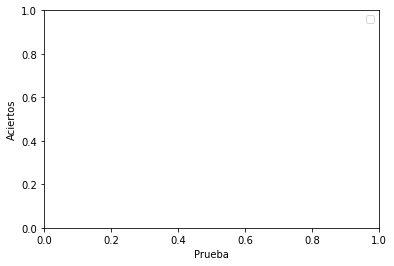

In [33]:
set_wilcoxon()

### Model and optimizers

Test [optimizer](https://keras.io/optimizers/) parameter with `sgd`, `adadelta` or `adam` values in order to check the final precision achieved.

In [ ]:
print(f'loss: {loss:.2f} acc: {acc:.2f}')

NameError: ignored

In [ ]:
print(model.summary())

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_150 (Conv2D)          (None, 28, 28, 6)         456       
_________________________________________________________________
activation_375 (Activation)  (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d_150 (MaxPoolin (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 10, 10, 16)        2416      
_________________________________________________________________
activation_376 (Activation)  (None, 10, 10, 16)        0         
_________________________________________________________________
max_pooling2d_151 (MaxPoolin (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_75 (Flatten)         (None, 400)             

## Prediction

### Testing AUC result for two and multiple classes

In [ ]:
y_scores = model.predict(X_test) # Confidence prediction per class
y_pred = y_scores.argmax(axis=1) # Select classes with most confidence prediction

if nb_classes ==  2:
  print(f'AUC {metrics.roc_auc_score(y_test, np.round(y_scores[:,1],2)):.4f} ')
else:
  print(f'AUC {metrics.roc_auc_score(y_test, y_scores, multi_class = "ovr"):.4f} ')

NameError: ignored

## More metrics about results

We can find more information about `precision`, `recall` and `f1` metrics in <https://en.wikipedia.org/wiki/Precision_and_recall>.

In [ ]:
print('Predictions', collections.Counter(y_pred),'\n')

print('Confusion matrix')
print(metrics.confusion_matrix(y_test,y_pred),'\n')

target_names = ['TUMOR', 'HEALTHY'] if nb_classes ==  2 else ['TUMOR','STROMA','COMPLEX','LYMPHO','DEBRIS','MUCOSA','ADIPOSE','EMPTY']

print(metrics.classification_report(y_test, y_pred, target_names=target_names))

NameError: ignored